# **Import Lib**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

import tensorflow as tf
from tensorflow import keras

from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.models import Sequential

import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')
myPath = '/content/drive/MyDrive/Topics/PL2023/'

Mounted at /content/drive


# **Load Data**

In [3]:
data = pd.read_csv(myPath+'data/data_under_scene_new.csv')
data.shape == data.dropna().shape # True: NaN data is not exist
pd.set_option('display.width', 300)
pd.options.display.float_format = '{:.4f}'.format
data

,time,Temperature,humidity,Precipitation,Surface_wind_speed,work_day,power_load
0,2020/1/1 0:00,-1.6000,31.8800,0.0000,0.6000,1,4204.6520
1,2020/1/1 0:15,-1.6000,31.8800,0.0000,0.6000,1,4154.3350
2,2020/1/1 0:30,-1.6000,31.8800,0.0000,0.6000,1,4122.4480
3,2020/1/1 0:45,-1.6000,31.8800,0.0000,0.6000,1,4103.3220
4,2020/1/1 1:00,-1.6800,30.8500,0.0000,0.3700,1,4074.6500
...,...,...,...,...,...,...,...
105211,2022/12/31 22:45,0.4100,60.2200,0.0000,2.2400,1,5286.2610
105212,2022/12/31 23:00,0.7500,60.1500,0.0000,2.0000,1,5220.8530
105213,2022/12/31 23:15,0.7500,60.1500,0.0000,2.0000,1,5219.8170
105214,2022/12/31 23:30,0.7500,60.1500,0.0000,2.0000,1,5165.6630


# **Data processing**

In [4]:
data.time = data.time.astype('datetime64[ns]')
timeseq = []
for x in data.time:
  timeseq.append(x.hour*60+x.minute)

In [5]:
timeseq = pd.Series(timeseq)
timeseq = timeseq.rename("timeseq")
data = pd.concat([data, timeseq], axis=1)
print(data)

                      time  Temperature  humidity  Precipitation  Surface_wind_speed  work_day  power_load  timeseq
0      2020-01-01 00:00:00      -1.6000   31.8800         0.0000              0.6000         1   4204.6520        0
1      2020-01-01 00:15:00      -1.6000   31.8800         0.0000              0.6000         1   4154.3350       15
2      2020-01-01 00:30:00      -1.6000   31.8800         0.0000              0.6000         1   4122.4480       30
3      2020-01-01 00:45:00      -1.6000   31.8800         0.0000              0.6000         1   4103.3220       45
4      2020-01-01 01:00:00      -1.6800   30.8500         0.0000              0.3700         1   4074.6500       60
...                    ...          ...       ...            ...                 ...       ...         ...      ...
105211 2022-12-31 22:45:00       0.4100   60.2200         0.0000              2.2400         1   5286.2610     1365
105212 2022-12-31 23:00:00       0.7500   60.1500         0.0000        

In [6]:
cols = data.columns.tolist()
print(cols)
cols = [cols[0], cols[-1]] + cols[1:7]
data = data[cols]

['time', 'Temperature', 'humidity', 'Precipitation', 'Surface_wind_speed', 'work_day', 'power_load', 'timeseq']


In [7]:
"""## Scaling Data"""
scaler = MinMaxScaler()
sdata = scaler.fit_transform(data.iloc[:,1:].to_numpy())
sdata[:,5] = (1-sdata[:,5])*.5
data.iloc[:,1:]=sdata
# scaler.inverse_transform(sdata)
print(data)

                      time  timeseq  Temperature  humidity  Precipitation  Surface_wind_speed  work_day  power_load
0      2020-01-01 00:00:00   0.0000       0.1773    0.3048         0.0000              0.0661    0.0000      0.1968
1      2020-01-01 00:15:00   0.0105       0.1773    0.3048         0.0000              0.0661    0.0000      0.1852
2      2020-01-01 00:30:00   0.0211       0.1773    0.3048         0.0000              0.0661    0.0000      0.1778
3      2020-01-01 00:45:00   0.0316       0.1773    0.3048         0.0000              0.0661    0.0000      0.1734
4      2020-01-01 01:00:00   0.0421       0.1758    0.2943         0.0000              0.0399    0.0000      0.1668
...                    ...      ...          ...       ...            ...                 ...       ...         ...
105211 2022-12-31 22:45:00   0.9579       0.2155    0.5940         0.0000              0.2528    0.0000      0.4463
105212 2022-12-31 23:00:00   0.9684       0.2219    0.5933         0.000

In [8]:
"""## SubSampling Data - sampling every hour"""
rate=4
subdata = data[::rate]
print(subdata)

                      time  timeseq  Temperature  humidity  Precipitation  Surface_wind_speed  work_day  power_load
0      2020-01-01 00:00:00   0.0000       0.1773    0.3048         0.0000              0.0661    0.0000      0.1968
4      2020-01-01 01:00:00   0.0421       0.1758    0.2943         0.0000              0.0399    0.0000      0.1668
8      2020-01-01 02:00:00   0.0842       0.1632    0.3301         0.0000              0.0581    0.0000      0.1559
12     2020-01-01 03:00:00   0.1263       0.1393    0.4584         0.0000              0.0615    0.0000      0.1493
16     2020-01-01 04:00:00   0.1684       0.1315    0.5010         0.0000              0.0649    0.0000      0.1381
...                    ...      ...          ...       ...            ...                 ...       ...         ...
105196 2022-12-31 19:00:00   0.8000       0.2563    0.5015         0.0000              0.3030    0.0000      0.5912
105200 2022-12-31 20:00:00   0.8421       0.2870    0.4270         0.000

In [9]:
subdata = subdata.reset_index()
print(subdata)

        index                time  timeseq  Temperature  humidity  Precipitation  Surface_wind_speed  work_day  power_load
0           0 2020-01-01 00:00:00   0.0000       0.1773    0.3048         0.0000              0.0661    0.0000      0.1968
1           4 2020-01-01 01:00:00   0.0421       0.1758    0.2943         0.0000              0.0399    0.0000      0.1668
2           8 2020-01-01 02:00:00   0.0842       0.1632    0.3301         0.0000              0.0581    0.0000      0.1559
3          12 2020-01-01 03:00:00   0.1263       0.1393    0.4584         0.0000              0.0615    0.0000      0.1493
4          16 2020-01-01 04:00:00   0.1684       0.1315    0.5010         0.0000              0.0649    0.0000      0.1381
...       ...                 ...      ...          ...       ...            ...                 ...       ...         ...
26299  105196 2022-12-31 19:00:00   0.8000       0.2563    0.5015         0.0000              0.3030    0.0000      0.5912
26300  105200 20

In [10]:
subdata.to_csv(myPath+'data/data_minmax_scale_new.csv')

In [11]:
period_train = ('2020-01-01 00:00:00','2021-12-31 23:45:00')
period_test = ('2022-01-01 00:00:00', '2022-12-31 23:45:00')
data_train = subdata[subdata.time.between(period_train[0], period_train[1])]
data_test = subdata[subdata.time.between(period_test[0], period_test[1])]
X_train = data_train.to_numpy()
X_test = data_test.to_numpy()

In [12]:
Y_train = data_train.power_load
Y_test = data_test.power_load
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(17544, 9) (17544,)
(8760, 9) (8760,)


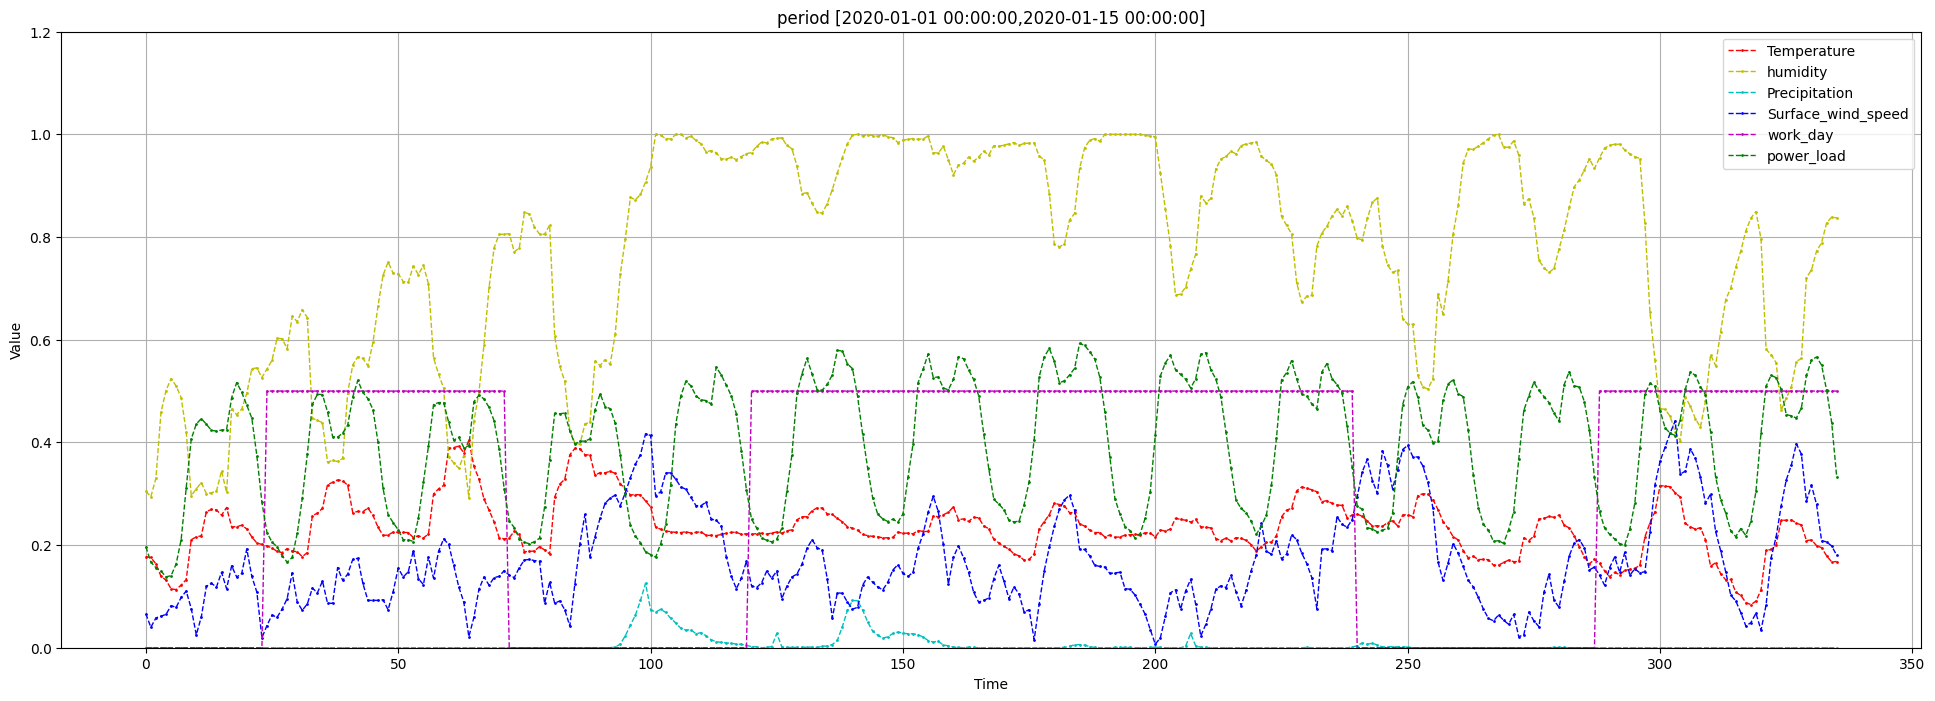

In [13]:
i0 = 24*30*0
i1 = i0+24*14
features = cols
markColors = ['r.--', 'y.--', 'c.--', 'b.--', 'm.--', 'g.--']
plt.rcParams['figure.figsize'] = [24, 8]
for j in range(6):
  plt.plot(data_train[features[j+2]][i0:i1], markColors[j], label=features[j+2], linewidth=1, markersize=2)
plt.title('period [' + str(data.iloc[4*i0].time)+','+str(data.iloc[4*i1].time)+']')
plt.xticks(rotation=0)
plt.ylabel('Value')
plt.xlabel('Time')
plt.ylim([0, 1.2])
plt.grid(True)
plt.legend()
plt.show()

# **Split and Multiframe**

In [14]:
"""## Multiframe data setup"""
"""## 365 * 24 * 4=35,040, 365 * 24=8,760 trainging data set count 305 * 24=7,320"""
def split_sequences(sequences, n_steps, n_prediction):
  X = list();
  n = len(sequences)-n_steps-n_prediction+1
  for i in range(n):
    x = sequences[i:i+n_steps,:]
    X.append(x)
  return array(X)

In [15]:
cols = data.columns.tolist()
print(cols)

['time', 'timeseq', 'Temperature', 'humidity', 'Precipitation', 'Surface_wind_speed', 'work_day', 'power_load']


In [16]:
#features =['timeseq','temperature','humidity','surface_wind_speed','work_day','power_load']
features =['timeseq','Temperature','humidity','Precipitation','Surface_wind_speed','work_day','power_load']
target = 'power_load'
X_train = data_train.loc[:, features].to_numpy()
X_test = data_test.loc[:,features].to_numpy()
n_features = len(features)

In [17]:
print(X_train.shape)
print(X_train)

(17544, 7)
[[0.         0.17729689 0.30482702 ... 0.06605923 0.         0.19678432]
 [0.04210526 0.17577828 0.29431575 ... 0.03986333 0.         0.16679757]
 [0.08421053 0.16324981 0.33013573 ... 0.05808656 0.         0.1558648 ]
 ...
 [0.88421053 0.22095672 0.57812022 ... 0.18451025 0.5        0.5910514 ]
 [0.92631579 0.18602885 0.65710787 ... 0.19817768 0.5        0.53289138]
 [0.96842105 0.19210326 0.65271967 ... 0.19476082 0.5        0.46393538]]


In [18]:
Y_train = data_train.power_load
Y_test = data_test.power_load

In [19]:
print(Y_train.to_numpy())

[0.19678432 0.16679757 0.1558648  ... 0.5910514  0.53289138 0.46393538]


# **Set parameters**

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_steps_1 = 4  # Squence data (48 = 1 day), (720 = 15days), (1440 = 30days)
n_prediction_1 = 1

n_steps_2 = 10
n_prediction_2 = 3

n_steps_3 = 12
n_prediction_3 = 5

np.set_printoptions(edgeitems=10, linewidth=130, formatter=dict(float=lambda x: "%6.4f" % x))

In [21]:
print(X_train, X_train.shape)
print(Y_train)

[[0.0000 0.1773 0.3048 0.0000 0.0661 0.0000 0.1968]
 [0.0421 0.1758 0.2943 0.0000 0.0399 0.0000 0.1668]
 [0.0842 0.1632 0.3301 0.0000 0.0581 0.0000 0.1559]
 [0.1263 0.1393 0.4584 0.0000 0.0615 0.0000 0.1493]
 [0.1684 0.1315 0.5010 0.0000 0.0649 0.0000 0.1381]
 [0.2105 0.1148 0.5244 0.0000 0.0820 0.0000 0.1403]
 [0.2526 0.1131 0.5098 0.0000 0.0786 0.0000 0.1630]
 [0.2947 0.1221 0.4874 0.0000 0.0979 0.0000 0.2105]
 [0.3368 0.1327 0.4210 0.0000 0.1105 0.0000 0.3114]
 [0.3789 0.2105 0.2962 0.0000 0.0763 0.0000 0.4065]
 ...
 [0.5895 0.3123 0.3049 0.0000 0.0558 0.5000 0.5640]
 [0.6316 0.3119 0.3072 0.0000 0.0547 0.5000 0.5407]
 [0.6737 0.3333 0.2096 0.0000 0.0216 0.5000 0.5602]
 [0.7158 0.2950 0.3359 0.0000 0.0581 0.5000 0.6178]
 [0.7579 0.2811 0.3832 0.0000 0.0251 0.5000 0.6476]
 [0.8000 0.2608 0.4653 0.0000 0.0604 0.5000 0.6135]
 [0.8421 0.2306 0.5572 0.0000 0.1276 0.5000 0.6197]
 [0.8842 0.2210 0.5781 0.0000 0.1845 0.5000 0.5911]
 [0.9263 0.1860 0.6571 0.0000 0.1982 0.5000 0.5329]
 [0.968

In [22]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=4, n_prediction=1):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.n_prediction = n_prediction
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i < self.X.shape[0] - (self.sequence_length + self.n_prediction):
            x = self.X[i:(i + self.sequence_length), :]
        else:
            i = self.X.shape[0] - (self.sequence_length + self.n_prediction)
            x = self.X[i:(i + self.sequence_length), :]
        return x, self.y[i + self.sequence_length + self.n_prediction - 1]

In [23]:
batch_size = 200
train_dataset1 = SequenceDataset(
    data_train,
    target=target,
    features=features,
    sequence_length=n_steps_1,
    n_prediction = n_prediction_1
)
test_dataset1 = SequenceDataset(
    data_test,
    target=target,
    features=features,
    sequence_length=n_steps_1,
    n_prediction = n_prediction_1
)

train_dataset2 = SequenceDataset(
    data_train,
    target=target,
    features=features,
    sequence_length=n_steps_2,
    n_prediction = n_prediction_2
)
test_dataset2 = SequenceDataset(
    data_test,
    target=target,
    features=features,
    sequence_length=n_steps_2,
    n_prediction = n_prediction_2
)

train_dataset3 = SequenceDataset(
    data_train,
    target=target,
    features=features,
    sequence_length=n_steps_3,
    n_prediction = n_prediction_3
)
test_dataset3 = SequenceDataset(
    data_test,
    target=target,
    features=features,
    sequence_length=n_steps_3,
    n_prediction = n_prediction_3
)
train_loader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)
X1, y1 = next(iter(train_loader1))

print("Features shape:", X1.shape)
print("Target shape:", y1.shape)

train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)
X2, y2 = next(iter(train_loader2))

print("Features shape:", X2.shape)
print("Target shape:", y2.shape)

train_loader3 = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True)
test_loader3 = DataLoader(test_dataset3, batch_size=batch_size, shuffle=False)
X3, y3 = next(iter(train_loader3))

print("Features shape:", X3.shape)
print("Target shape:", y3.shape)


Features shape: torch.Size([200, 4, 7])
Target shape: torch.Size([200])
Features shape: torch.Size([200, 10, 7])
Target shape: torch.Size([200])
Features shape: torch.Size([200, 12, 7])
Target shape: torch.Size([200])


# **Self_Attention Model**

In [24]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.input_size = input_size  # this is the number of features in the input data at each time step
        self.hidden_size = hidden_size  # this is the hidden units in LSTM layer
        self.num_layers = num_layers  # this is the number of LSTM layers
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size, num_layers=self.num_layers, batch_first=True)
          # batch_first= True: input data will have the batch size as the first dimension

        self.linear = nn.Linear(in_features=self.hidden_size, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.
        return out

In [25]:
class SelfAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim, num_heads=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        # Linear layer
        self.emss = nn.Linear(input_dim, hidden_dim)
        # Attention layer
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=num_heads)
        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Attention mechanism
        features = self.emss(x)
        features = features.permute(1, 0, 2)
        query = torch.mean(features, dim=0, keepdim=True)
        #query = query.permute(1, 0, 2)
        attention_output, _ = self.attention(query, features, features)
        # Output layer
        out = self.fc(attention_output.squeeze(0)).flatten()
        return out

In [26]:
class LSTM_SelfAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, num_heads=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # Attention layer
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=num_heads)
        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # Forward propagation LSTM
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Attention mechanism
        features = out.permute(1, 0, 2)
        query = torch.mean(features, dim=0, keepdim=True)
        #query = query.permute(1, 0, 2)

        attention_output, _ = self.attention(query, features, features)
        # Output layer
        out = self.fc(attention_output.squeeze(0)).flatten()
        return out

# **Training**

In [27]:
input_size =  len(features)
output_size = 1
hidden_units = 4
hidden_units_group = [4]
num_layers = 10 # Hidden layer # 10 3 # 6
num_heads = 4
dropout_prob = 0.5
learning_rate = 0.00125

case_name = 'LSTM_nn_'+str(hidden_units)+'_ln_'+str(num_layers) # case name for graph

In [28]:
train_losses_1 = []
validation_losses_1 = []

train_losses_2 = []
validation_losses_2 = []

train_losses_3 = []
validation_losses_3 = []

train_losses_4 = []
validation_losses_4 = []

train_losses_5 = []
validation_losses_5 = []

train_losses_6 = []
validation_losses_6 = []

train_losses_7 = []
validation_losses_7 = []

train_losses_8 = []
validation_losses_8 = []

train_losses_9 = []
validation_losses_9 = []

best_val_loss = float('inf')

loss_function = nn.MSELoss()

epochs = 300

In [29]:
train_losses_1 = []
validation_losses_1 = []
def train_model(data_loader, model, loss_function,train_losses,optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / num_batches
    train_losses.append(avg_loss)
    print(f"Train loss: %6.4f  " % avg_loss, end="")

def test_model(data_loader, model, loss_function,validation_losses):
    num_batches = len(data_loader)
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            # print(X, y)
            output = model(X)
            total_loss += loss_function(output, y).item()
    avg_loss = total_loss / num_batches
    validation_losses.append(avg_loss)
    print(f"Test loss: %6.4f" % avg_loss)

In [30]:
train_losses_1 = []
validation_losses_1 = []
model_LSTM_Model1= LSTMModel(input_size=input_size, hidden_size=hidden_units, num_layers=num_layers).to(device)

optimizer1 = torch.optim.Adam(model_LSTM_Model1.parameters(), lr=learning_rate)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader1, model_LSTM_Model1, loss_function, train_losses_1,optimizer=optimizer1)
    test_model(test_loader1, model_LSTM_Model1, loss_function,validation_losses_1)


torch.save(model_LSTM_Model1.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp1_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp1_MSE.pth')

Epoch 0 Train loss: 0.3189  Test loss: 0.0573
Epoch 1 Train loss: 0.0166  Test loss: 0.0237
Epoch 2 Train loss: 0.0131  Test loss: 0.0211
Epoch 3 Train loss: 0.0118  Test loss: 0.0189
Epoch 4 Train loss: 0.0108  Test loss: 0.0174
Epoch 5 Train loss: 0.0100  Test loss: 0.0163
Epoch 6 Train loss: 0.0092  Test loss: 0.0149
Epoch 7 Train loss: 0.0085  Test loss: 0.0137
Epoch 8 Train loss: 0.0078  Test loss: 0.0125
Epoch 9 Train loss: 0.0070  Test loss: 0.0112
Epoch 10 Train loss: 0.0061  Test loss: 0.0095
Epoch 11 Train loss: 0.0051  Test loss: 0.0080
Epoch 12 Train loss: 0.0041  Test loss: 0.0064
Epoch 13 Train loss: 0.0032  Test loss: 0.0049
Epoch 14 Train loss: 0.0024  Test loss: 0.0037
Epoch 15 Train loss: 0.0020  Test loss: 0.0030
Epoch 16 Train loss: 0.0017  Test loss: 0.0027
Epoch 17 Train loss: 0.0016  Test loss: 0.0025
Epoch 18 Train loss: 0.0015  Test loss: 0.0023
Epoch 19 Train loss: 0.0015  Test loss: 0.0023
Epoch 20 Train loss: 0.0014  Test loss: 0.0022
Epoch 21 Train loss: 0.

In [31]:
train_losses_2 = []
validation_losses_2 = []
model_LSTM_Model2= LSTMModel(input_size=input_size, hidden_size=hidden_units, num_layers=num_layers).to(device)

optimizer2 = torch.optim.Adam(model_LSTM_Model2.parameters(), lr=learning_rate)

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader2, model_LSTM_Model2, loss_function, train_losses_2,optimizer=optimizer2)
    test_model(test_loader2, model_LSTM_Model2, loss_function,validation_losses_2)


torch.save(model_LSTM_Model2.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp2_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp2_MSE.pth')

Epoch 0 Train loss: 0.0187  Test loss: 0.0199
Epoch 1 Train loss: 0.0093  Test loss: 0.0110
Epoch 2 Train loss: 0.0055  Test loss: 0.0091
Epoch 3 Train loss: 0.0046  Test loss: 0.0085
Epoch 4 Train loss: 0.0043  Test loss: 0.0080
Epoch 5 Train loss: 0.0042  Test loss: 0.0077
Epoch 6 Train loss: 0.0040  Test loss: 0.0075
Epoch 7 Train loss: 0.0039  Test loss: 0.0074
Epoch 8 Train loss: 0.0038  Test loss: 0.0071
Epoch 9 Train loss: 0.0037  Test loss: 0.0069
Epoch 10 Train loss: 0.0036  Test loss: 0.0070
Epoch 11 Train loss: 0.0035  Test loss: 0.0066
Epoch 12 Train loss: 0.0034  Test loss: 0.0064
Epoch 13 Train loss: 0.0033  Test loss: 0.0063
Epoch 14 Train loss: 0.0032  Test loss: 0.0060
Epoch 15 Train loss: 0.0031  Test loss: 0.0059
Epoch 16 Train loss: 0.0031  Test loss: 0.0058
Epoch 17 Train loss: 0.0030  Test loss: 0.0057
Epoch 18 Train loss: 0.0029  Test loss: 0.0057
Epoch 19 Train loss: 0.0029  Test loss: 0.0056
Epoch 20 Train loss: 0.0028  Test loss: 0.0054
Epoch 21 Train loss: 0.

In [32]:
train_losses_3 = []
validation_losses_3 = []
model_LSTM_Model3= LSTMModel(input_size=input_size, hidden_size=hidden_units, num_layers=num_layers).to(device)

optimizer3 = torch.optim.Adam(model_LSTM_Model3.parameters(), lr=learning_rate)

scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader3, model_LSTM_Model3, loss_function, train_losses_3,optimizer=optimizer3)
    test_model(test_loader3, model_LSTM_Model3, loss_function,validation_losses_3)


torch.save(model_LSTM_Model3.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp3_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp3_MSE.pth')

Epoch 0 Train loss: 0.0672  Test loss: 0.0306
Epoch 1 Train loss: 0.0197  Test loss: 0.0292
Epoch 2 Train loss: 0.0181  Test loss: 0.0280
Epoch 3 Train loss: 0.0170  Test loss: 0.0266
Epoch 4 Train loss: 0.0160  Test loss: 0.0256
Epoch 5 Train loss: 0.0152  Test loss: 0.0245
Epoch 6 Train loss: 0.0144  Test loss: 0.0232
Epoch 7 Train loss: 0.0135  Test loss: 0.0220
Epoch 8 Train loss: 0.0124  Test loss: 0.0200
Epoch 9 Train loss: 0.0107  Test loss: 0.0172
Epoch 10 Train loss: 0.0083  Test loss: 0.0127
Epoch 11 Train loss: 0.0055  Test loss: 0.0087
Epoch 12 Train loss: 0.0043  Test loss: 0.0075
Epoch 13 Train loss: 0.0040  Test loss: 0.0073
Epoch 14 Train loss: 0.0038  Test loss: 0.0071
Epoch 15 Train loss: 0.0038  Test loss: 0.0068
Epoch 16 Train loss: 0.0037  Test loss: 0.0067
Epoch 17 Train loss: 0.0036  Test loss: 0.0066
Epoch 18 Train loss: 0.0035  Test loss: 0.0066
Epoch 19 Train loss: 0.0035  Test loss: 0.0065
Epoch 20 Train loss: 0.0035  Test loss: 0.0067
Epoch 21 Train loss: 0.

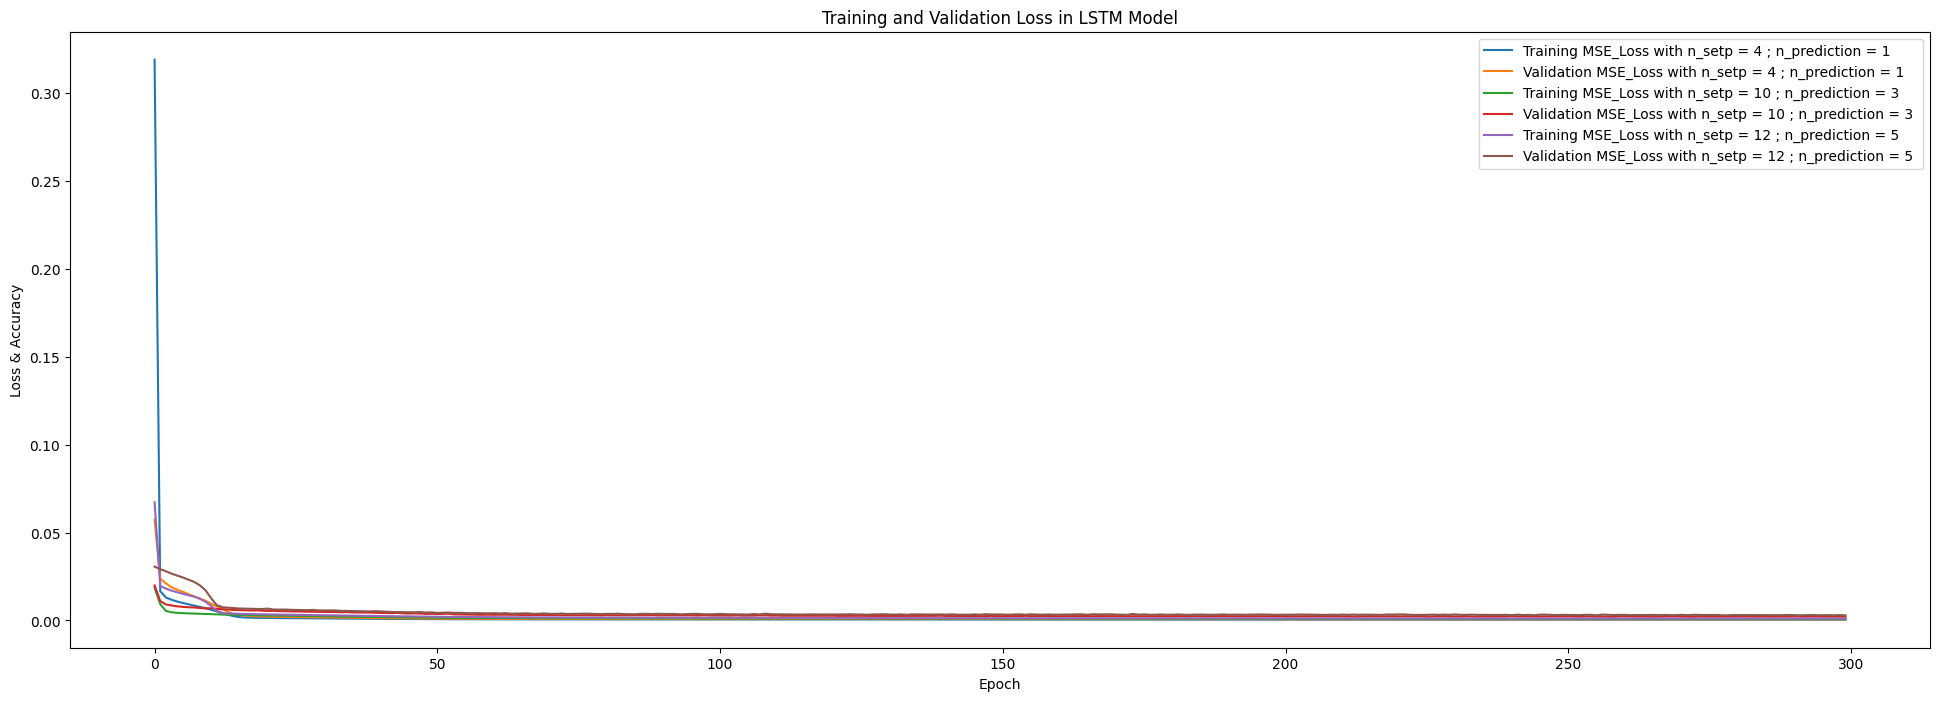

In [33]:
plt.figure()
plt.plot(train_losses_1, label='Training MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(validation_losses_1, label='Validation MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(train_losses_2, label='Training MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(validation_losses_2, label='Validation MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(train_losses_3, label='Training MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.plot(validation_losses_3, label='Validation MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.title('Training and Validation Loss in LSTM Model')
plt.legend()
plt.show()

In [34]:
train_losses_4 = []
validation_losses_4 = []
model_LSTM_SelfAttentionModel1= LSTM_SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units, num_layers=num_layers, output_dim=output_size,num_heads=num_heads).to(device)

optimizer1 = torch.optim.Adam(model_LSTM_SelfAttentionModel1.parameters(), lr=learning_rate)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader1, model_LSTM_SelfAttentionModel1, loss_function, train_losses_4,optimizer=optimizer1)
    test_model(test_loader1, model_LSTM_SelfAttentionModel1, loss_function,validation_losses_4)


torch.save(model_LSTM_SelfAttentionModel1.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp1_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp1_MSE.pth')

Epoch 0 Train loss: 0.3416  Test loss: 0.0337
Epoch 1 Train loss: 0.0157  Test loss: 0.0248
Epoch 2 Train loss: 0.0153  Test loss: 0.0250
Epoch 3 Train loss: 0.0153  Test loss: 0.0251
Epoch 4 Train loss: 0.0153  Test loss: 0.0253
Epoch 5 Train loss: 0.0153  Test loss: 0.0255
Epoch 6 Train loss: 0.0153  Test loss: 0.0250
Epoch 7 Train loss: 0.0153  Test loss: 0.0256
Epoch 8 Train loss: 0.0153  Test loss: 0.0254
Epoch 9 Train loss: 0.0153  Test loss: 0.0253
Epoch 10 Train loss: 0.0153  Test loss: 0.0246
Epoch 11 Train loss: 0.0153  Test loss: 0.0244
Epoch 12 Train loss: 0.0153  Test loss: 0.0243
Epoch 13 Train loss: 0.0153  Test loss: 0.0257
Epoch 14 Train loss: 0.0149  Test loss: 0.0220
Epoch 15 Train loss: 0.0083  Test loss: 0.0072
Epoch 16 Train loss: 0.0027  Test loss: 0.0027
Epoch 17 Train loss: 0.0013  Test loss: 0.0017
Epoch 18 Train loss: 0.0010  Test loss: 0.0014
Epoch 19 Train loss: 0.0009  Test loss: 0.0013
Epoch 20 Train loss: 0.0008  Test loss: 0.0012
Epoch 21 Train loss: 0.

In [35]:
train_losses_5 = []
validation_losses_5 = []
model_LSTM_SelfAttentionModel2= LSTM_SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units, num_layers=num_layers, output_dim=output_size,num_heads=num_heads).to(device)

optimizer2 = torch.optim.Adam(model_LSTM_SelfAttentionModel2.parameters(), lr=learning_rate)

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader2, model_LSTM_SelfAttentionModel2, loss_function, train_losses_5,optimizer=optimizer2)
    test_model(test_loader2, model_LSTM_SelfAttentionModel2, loss_function,validation_losses_5)


torch.save(model_LSTM_SelfAttentionModel2.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp2_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp2_MSE.pth')

Epoch 0 Train loss: 0.2957  Test loss: 0.0340
Epoch 1 Train loss: 0.0156  Test loss: 0.0249
Epoch 2 Train loss: 0.0153  Test loss: 0.0248
Epoch 3 Train loss: 0.0153  Test loss: 0.0250
Epoch 4 Train loss: 0.0153  Test loss: 0.0251
Epoch 5 Train loss: 0.0153  Test loss: 0.0246
Epoch 6 Train loss: 0.0153  Test loss: 0.0250
Epoch 7 Train loss: 0.0153  Test loss: 0.0251
Epoch 8 Train loss: 0.0153  Test loss: 0.0251
Epoch 9 Train loss: 0.0153  Test loss: 0.0246
Epoch 10 Train loss: 0.0153  Test loss: 0.0254
Epoch 11 Train loss: 0.0153  Test loss: 0.0245
Epoch 12 Train loss: 0.0153  Test loss: 0.0246
Epoch 13 Train loss: 0.0153  Test loss: 0.0247
Epoch 14 Train loss: 0.0153  Test loss: 0.0253
Epoch 15 Train loss: 0.0153  Test loss: 0.0251
Epoch 16 Train loss: 0.0153  Test loss: 0.0246
Epoch 17 Train loss: 0.0153  Test loss: 0.0242
Epoch 18 Train loss: 0.0153  Test loss: 0.0246
Epoch 19 Train loss: 0.0100  Test loss: 0.0107
Epoch 20 Train loss: 0.0037  Test loss: 0.0080
Epoch 21 Train loss: 0.

In [57]:
train_losses_6 = []
validation_losses_6 = []
model_LSTM_SelfAttentionModel3= LSTM_SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units, num_layers=num_layers, output_dim=output_size,num_heads=num_heads).to(device)

optimizer3 = torch.optim.Adam(model_LSTM_SelfAttentionModel3.parameters(), lr=learning_rate)

scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader3, model_LSTM_SelfAttentionModel3, loss_function, train_losses_6,optimizer=optimizer3)
    test_model(test_loader3, model_LSTM_SelfAttentionModel3, loss_function,validation_losses_6)


torch.save(model_LSTM_SelfAttentionModel3.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp3_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp3_MSE.pth')

Epoch 0 Train loss: 0.0174  Test loss: 0.0250
Epoch 1 Train loss: 0.0153  Test loss: 0.0249
Epoch 2 Train loss: 0.0153  Test loss: 0.0252
Epoch 3 Train loss: 0.0153  Test loss: 0.0249
Epoch 4 Train loss: 0.0153  Test loss: 0.0255
Epoch 5 Train loss: 0.0153  Test loss: 0.0248
Epoch 6 Train loss: 0.0153  Test loss: 0.0253
Epoch 7 Train loss: 0.0153  Test loss: 0.0248
Epoch 8 Train loss: 0.0153  Test loss: 0.0249
Epoch 9 Train loss: 0.0153  Test loss: 0.0246
Epoch 10 Train loss: 0.0153  Test loss: 0.0249
Epoch 11 Train loss: 0.0153  Test loss: 0.0250
Epoch 12 Train loss: 0.0153  Test loss: 0.0252
Epoch 13 Train loss: 0.0153  Test loss: 0.0254
Epoch 14 Train loss: 0.0153  Test loss: 0.0257
Epoch 15 Train loss: 0.0153  Test loss: 0.0251
Epoch 16 Train loss: 0.0153  Test loss: 0.0255
Epoch 17 Train loss: 0.0146  Test loss: 0.0202
Epoch 18 Train loss: 0.0086  Test loss: 0.0089
Epoch 19 Train loss: 0.0040  Test loss: 0.0062
Epoch 20 Train loss: 0.0029  Test loss: 0.0058
Epoch 21 Train loss: 0.

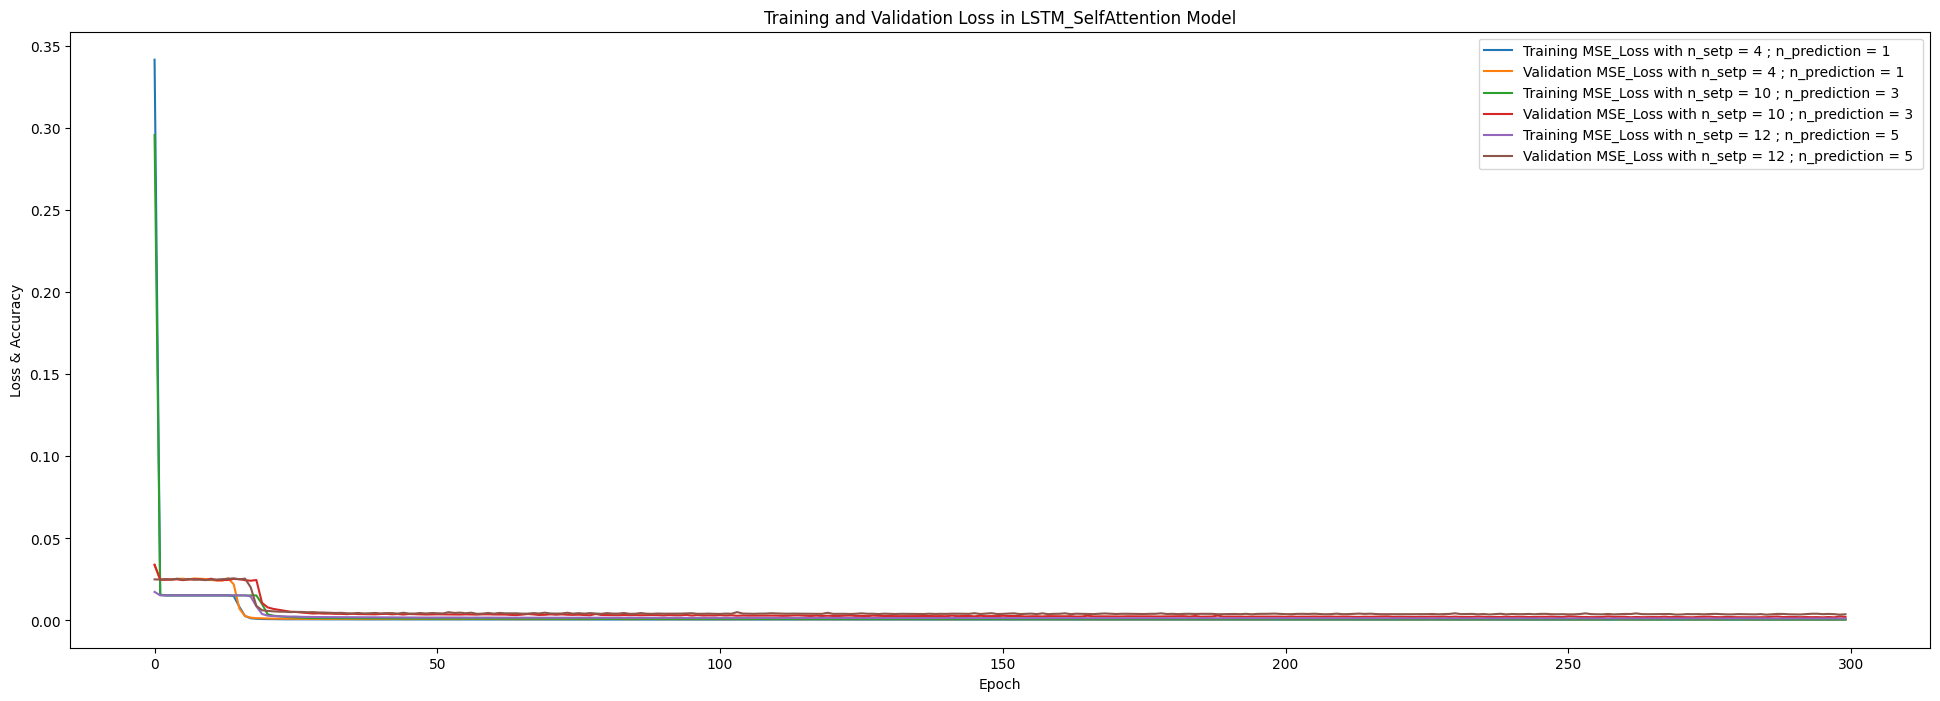

In [58]:
plt.figure()
plt.plot(train_losses_4, label='Training MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(validation_losses_4, label='Validation MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(train_losses_5, label='Training MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(validation_losses_5, label='Validation MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(train_losses_6, label='Training MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.plot(validation_losses_6, label='Validation MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.title('Training and Validation Loss in LSTM_SelfAttention Model')
plt.legend()
plt.show()

In [38]:
train_losses_7 = []
validation_losses_7 = []
model_SelfAttentionModel1= SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units,output_dim=output_size,num_heads=num_heads).to(device)

optimizer1 = torch.optim.Adam(model_SelfAttentionModel1.parameters(), lr=learning_rate)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader1, model_SelfAttentionModel1, loss_function, train_losses_7,optimizer=optimizer1)
    test_model(test_loader1, model_SelfAttentionModel1, loss_function,validation_losses_7)


torch.save(model_SelfAttentionModel1.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp1_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp1_MSE.pth')

Epoch 0 Train loss: 0.1368  Test loss: 0.0241
Epoch 1 Train loss: 0.0174  Test loss: 0.0244
Epoch 2 Train loss: 0.0156  Test loss: 0.0217
Epoch 3 Train loss: 0.0141  Test loss: 0.0196
Epoch 4 Train loss: 0.0128  Test loss: 0.0182
Epoch 5 Train loss: 0.0115  Test loss: 0.0163
Epoch 6 Train loss: 0.0104  Test loss: 0.0152
Epoch 7 Train loss: 0.0094  Test loss: 0.0137
Epoch 8 Train loss: 0.0085  Test loss: 0.0112
Epoch 9 Train loss: 0.0075  Test loss: 0.0096
Epoch 10 Train loss: 0.0064  Test loss: 0.0078
Epoch 11 Train loss: 0.0052  Test loss: 0.0063
Epoch 12 Train loss: 0.0042  Test loss: 0.0051
Epoch 13 Train loss: 0.0036  Test loss: 0.0045
Epoch 14 Train loss: 0.0034  Test loss: 0.0042
Epoch 15 Train loss: 0.0033  Test loss: 0.0041
Epoch 16 Train loss: 0.0032  Test loss: 0.0041
Epoch 17 Train loss: 0.0031  Test loss: 0.0040
Epoch 18 Train loss: 0.0030  Test loss: 0.0039
Epoch 19 Train loss: 0.0029  Test loss: 0.0038
Epoch 20 Train loss: 0.0028  Test loss: 0.0037
Epoch 21 Train loss: 0.

In [39]:
train_losses_8 = []
validation_losses_8 = []
model_SelfAttentionModel2= SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units,output_dim=output_size,num_heads=num_heads).to(device)

optimizer2 = torch.optim.Adam(model_SelfAttentionModel2.parameters(), lr=learning_rate)

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader2, model_SelfAttentionModel2, loss_function, train_losses_8,optimizer=optimizer2)
    test_model(test_loader2, model_SelfAttentionModel2, loss_function,validation_losses_8)


torch.save(model_SelfAttentionModel2.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp2_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp2_MSE.pth')

Epoch 0 Train loss: 0.0140  Test loss: 0.0193
Epoch 1 Train loss: 0.0092  Test loss: 0.0083
Epoch 2 Train loss: 0.0044  Test loss: 0.0075
Epoch 3 Train loss: 0.0041  Test loss: 0.0075
Epoch 4 Train loss: 0.0041  Test loss: 0.0073
Epoch 5 Train loss: 0.0040  Test loss: 0.0073
Epoch 6 Train loss: 0.0040  Test loss: 0.0072
Epoch 7 Train loss: 0.0040  Test loss: 0.0073
Epoch 8 Train loss: 0.0040  Test loss: 0.0073
Epoch 9 Train loss: 0.0040  Test loss: 0.0072
Epoch 10 Train loss: 0.0040  Test loss: 0.0072
Epoch 11 Train loss: 0.0040  Test loss: 0.0071
Epoch 12 Train loss: 0.0040  Test loss: 0.0072
Epoch 13 Train loss: 0.0040  Test loss: 0.0071
Epoch 14 Train loss: 0.0040  Test loss: 0.0073
Epoch 15 Train loss: 0.0040  Test loss: 0.0071
Epoch 16 Train loss: 0.0039  Test loss: 0.0070
Epoch 17 Train loss: 0.0039  Test loss: 0.0069
Epoch 18 Train loss: 0.0038  Test loss: 0.0069
Epoch 19 Train loss: 0.0038  Test loss: 0.0068
Epoch 20 Train loss: 0.0037  Test loss: 0.0067
Epoch 21 Train loss: 0.

In [40]:
train_losses_9 = []
validation_losses_9 = []
model_SelfAttentionModel3= SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units,output_dim=output_size,num_heads=num_heads).to(device)

optimizer3 = torch.optim.Adam(model_SelfAttentionModel3.parameters(), lr=learning_rate)

scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader3, model_SelfAttentionModel3, loss_function, train_losses_9,optimizer=optimizer3)
    test_model(test_loader3, model_SelfAttentionModel3, loss_function,validation_losses_9)


torch.save(model_SelfAttentionModel3.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp3_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp3_MSE.pth')

Epoch 0 Train loss: 0.0249  Test loss: 0.0273
Epoch 1 Train loss: 0.0161  Test loss: 0.0247
Epoch 2 Train loss: 0.0148  Test loss: 0.0236
Epoch 3 Train loss: 0.0133  Test loss: 0.0206
Epoch 4 Train loss: 0.0108  Test loss: 0.0148
Epoch 5 Train loss: 0.0070  Test loss: 0.0092
Epoch 6 Train loss: 0.0046  Test loss: 0.0070
Epoch 7 Train loss: 0.0039  Test loss: 0.0066
Epoch 8 Train loss: 0.0038  Test loss: 0.0068
Epoch 9 Train loss: 0.0038  Test loss: 0.0068
Epoch 10 Train loss: 0.0038  Test loss: 0.0068
Epoch 11 Train loss: 0.0038  Test loss: 0.0069
Epoch 12 Train loss: 0.0038  Test loss: 0.0068
Epoch 13 Train loss: 0.0038  Test loss: 0.0068
Epoch 14 Train loss: 0.0038  Test loss: 0.0068
Epoch 15 Train loss: 0.0038  Test loss: 0.0068
Epoch 16 Train loss: 0.0038  Test loss: 0.0068
Epoch 17 Train loss: 0.0037  Test loss: 0.0068
Epoch 18 Train loss: 0.0037  Test loss: 0.0067
Epoch 19 Train loss: 0.0037  Test loss: 0.0066
Epoch 20 Train loss: 0.0036  Test loss: 0.0065
Epoch 21 Train loss: 0.

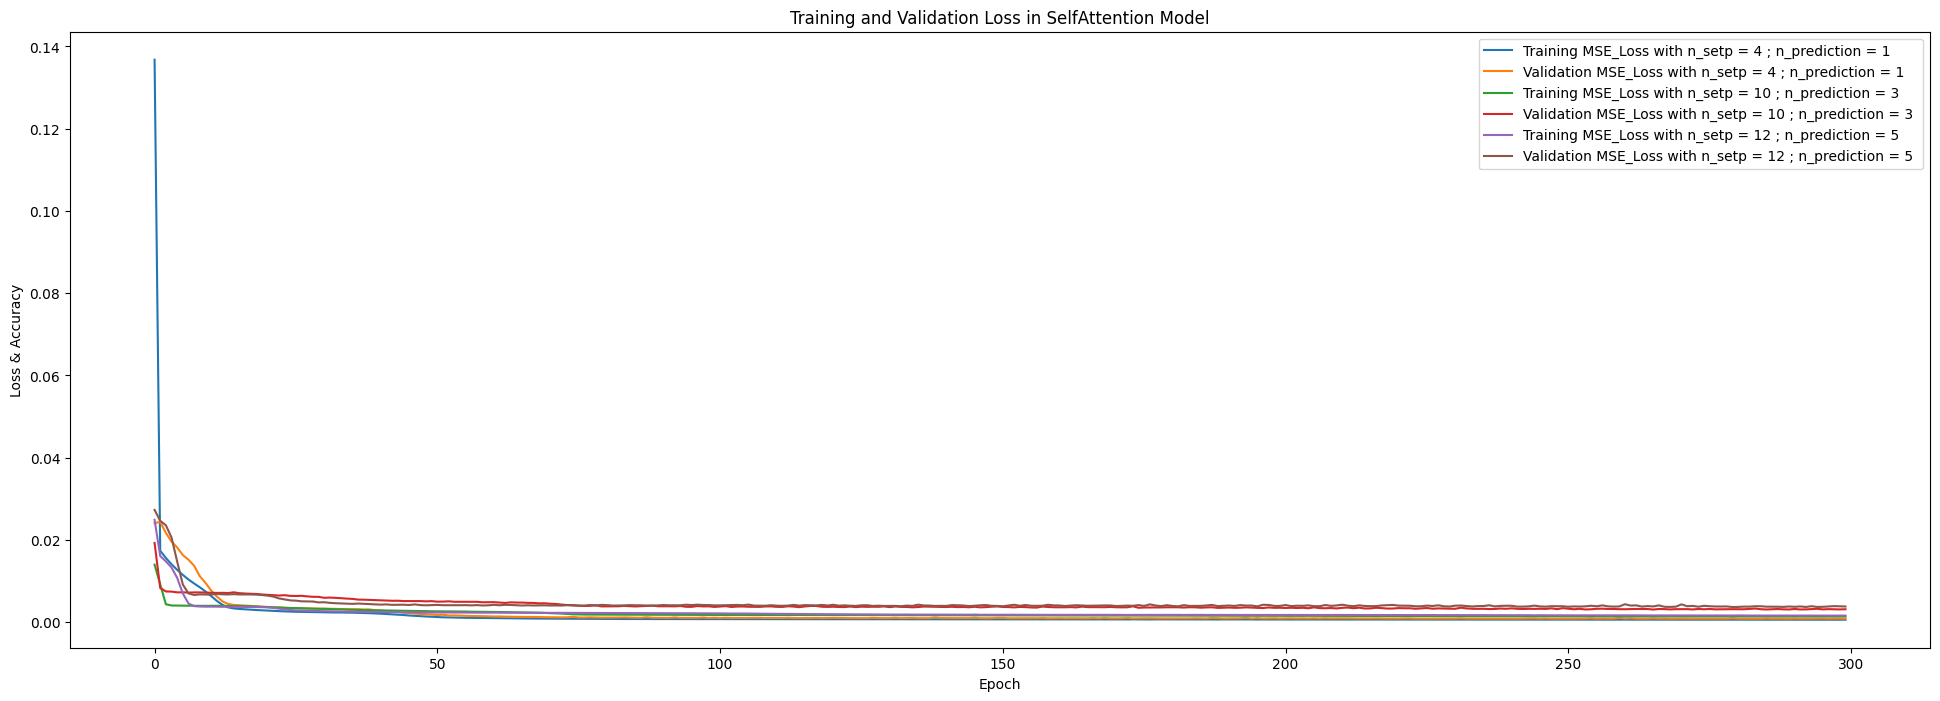

In [41]:
plt.figure()
plt.plot(train_losses_7, label='Training MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(validation_losses_7, label='Validation MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(train_losses_8, label='Training MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(validation_losses_8, label='Validation MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(train_losses_9, label='Training MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.plot(validation_losses_9, label='Validation MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.title('Training and Validation Loss in SelfAttention Model')
plt.legend()
plt.show()

# **Prediction result**

In [59]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output

In [60]:
Y_train1 = data_train.power_load
rY_train1 = np.roll(Y_train1, -(n_steps_1 + n_prediction_1-1))
rY_train1[-(n_steps_1+n_prediction_1-1):] = 0

Y_train2 = data_train.power_load
rY_train2 = np.roll(Y_train1, -(n_steps_2 + n_prediction_2-1))
rY_train2[-(n_steps_2+n_prediction_2-1):] = 0

Y_train3 = data_train.power_load
rY_train3 = np.roll(Y_train1, -(n_steps_3 + n_prediction_3-1))
rY_train3[-(n_steps_3+n_prediction_3-1):] = 0

print(Y_train1)
print(rY_train1)
print(Y_train2)
print(rY_train2)
print(Y_train3)
print(rY_train3)

0       0.1968
1       0.1668
2       0.1559
3       0.1493
4       0.1381
         ...  
17539   0.6135
17540   0.6197
17541   0.5911
17542   0.5329
17543   0.4639
Name: power_load, Length: 17544, dtype: float64
[0.1381 0.1403 0.1630 0.2105 0.3114 0.4065 0.4359 0.4464 0.4353 0.4234 ... 0.6476 0.6135 0.6197 0.5911 0.5329 0.4639 0.0000
 0.0000 0.0000 0.0000]
0       0.1968
1       0.1668
2       0.1559
3       0.1493
4       0.1381
         ...  
17539   0.6135
17540   0.6197
17541   0.5911
17542   0.5329
17543   0.4639
Name: power_load, Length: 17544, dtype: float64
[0.4353 0.4234 0.4220 0.4241 0.4250 0.4871 0.5165 0.4978 0.4726 0.4473 ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 0.0000]
0       0.1968
1       0.1668
2       0.1559
3       0.1493
4       0.1381
         ...  
17539   0.6135
17540   0.6197
17541   0.5911
17542   0.5329
17543   0.4639
Name: power_load, Length: 17544, dtype: float64
[0.4250 0.4871 0.5165 0.4978 0.4726 0.4473 0.3738 0.2832 0.2244 0.2

In [61]:
Y_test1 = data_test.power_load
rY_test1 = np.roll(Y_test1, -(n_steps_1 + n_prediction_1-1))
rY_test1[-(n_steps_1 + n_prediction_1 - 1):] = 0

Y_test2 = data_test.power_load
rY_test2 = np.roll(Y_test2, -(n_steps_2 + n_prediction_2-1))
rY_test2[-(n_steps_2 + n_prediction_2 - 1):] = 0

Y_test3 = data_test.power_load
rY_test3 = np.roll(Y_test3, -(n_steps_3 + n_prediction_3-1))
rY_test3[-(n_steps_3 + n_prediction_3 - 1):] = 0

print(Y_test1)
print(rY_test1)
print(Y_test2)
print(rY_test2)
print(Y_test3)
print(rY_test3)

17544   0.4007
17545   0.3755
17546   0.3531
17547   0.3291
17548   0.3105
         ...  
26299   0.5912
26300   0.5849
26301   0.5608
26302   0.5123
26303   0.4312
Name: power_load, Length: 8760, dtype: float64
[0.3105 0.3020 0.3288 0.3650 0.4407 0.4813 0.4710 0.4574 0.4276 0.3689 ... 0.6213 0.5912 0.5849 0.5608 0.5123 0.4312 0.0000
 0.0000 0.0000 0.0000]
17544   0.4007
17545   0.3755
17546   0.3531
17547   0.3291
17548   0.3105
         ...  
26299   0.5912
26300   0.5849
26301   0.5608
26302   0.5123
26303   0.4312
Name: power_load, Length: 8760, dtype: float64
[0.4276 0.3689 0.3513 0.3585 0.3966 0.4973 0.5745 0.5713 0.5610 0.5265 ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 0.0000]
17544   0.4007
17545   0.3755
17546   0.3531
17547   0.3291
17548   0.3105
         ...  
26299   0.5912
26300   0.5849
26301   0.5608
26302   0.5123
26303   0.4312
Name: power_load, Length: 8760, dtype: float64
[0.3966 0.4973 0.5745 0.5713 0.5610 0.5265 0.4824 0.3978 0.3473 0.3241

In [62]:
ystar_col = "Model forecast"
train_eval_loader1 = DataLoader(train_dataset1, batch_size=100, shuffle=False)
train_eval_loader2 = DataLoader(train_dataset2, batch_size=100, shuffle=False)
train_eval_loader3 = DataLoader(train_dataset3, batch_size=100, shuffle=False)

dt_train1 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test1 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train2 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test2 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train3 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test3 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train4 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test4 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train5 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test5 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train6 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test6 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train7 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test7 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train8 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test8 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train9 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test9 = subdata[subdata.time.between(period_test[0], period_test[1])]


dt_train1[ystar_col] = predict(train_eval_loader1, model_LSTM_Model1).numpy()
dt_test1[ystar_col] = predict(test_loader1, model_LSTM_Model1).numpy()
dt_train2[ystar_col] = predict(train_eval_loader2, model_LSTM_Model2).numpy()
dt_test2[ystar_col] = predict(test_loader2, model_LSTM_Model2).numpy()
dt_train3[ystar_col] = predict(train_eval_loader3, model_LSTM_Model3).numpy()
dt_test3[ystar_col] = predict(test_loader3, model_LSTM_Model3).numpy()
dt_train4[ystar_col] = predict(train_eval_loader1, model_LSTM_SelfAttentionModel1).numpy()
dt_test4[ystar_col] = predict(test_loader1, model_LSTM_SelfAttentionModel1).numpy()
dt_train5[ystar_col] = predict(train_eval_loader2, model_LSTM_SelfAttentionModel2).numpy()
dt_test5[ystar_col] = predict(test_loader2, model_LSTM_SelfAttentionModel2).numpy()
dt_train6[ystar_col] = predict(train_eval_loader3, model_LSTM_SelfAttentionModel3).numpy()
dt_test6[ystar_col] = predict(test_loader3, model_LSTM_SelfAttentionModel3).numpy()
dt_train7[ystar_col] = predict(train_eval_loader1, model_SelfAttentionModel1).numpy()
dt_test7[ystar_col] = predict(test_loader1, model_SelfAttentionModel1).numpy()
dt_train8[ystar_col] = predict(train_eval_loader2, model_SelfAttentionModel2).numpy()
dt_test8[ystar_col] = predict(test_loader2, model_SelfAttentionModel2).numpy()
dt_train9[ystar_col] = predict(train_eval_loader3, model_SelfAttentionModel3).numpy()
dt_test9[ystar_col] = predict(test_loader3, model_SelfAttentionModel3).numpy()


n1 = 500
n2 = n1+batch_size

print(rY_train1[n1 :n2])
print(rY_train2[n1 :n2])
print(rY_train3[n1 :n2])
print(dt_train1[ystar_col][n1 :n2])
print(dt_train2[ystar_col][n1 :n2])
print(dt_train3[ystar_col][n1 :n2])
print(dt_train4[ystar_col][n1 :n2])
print(dt_train5[ystar_col][n1 :n2])
print(dt_train6[ystar_col][n1 :n2])
print(dt_train7[ystar_col][n1 :n2])
print(dt_train8[ystar_col][n1 :n2])
print(dt_train9[ystar_col][n1 :n2])
print(rY_test1[n1 :n2])
print(rY_test2[n1 :n2])
print(rY_test3[n1 :n2])
print(dt_test1[ystar_col][n1 :n2])
print(dt_test2[ystar_col][n1 :n2])
print(dt_test3[ystar_col][n1 :n2])
print(dt_test4[ystar_col][n1 :n2])
print(dt_test5[ystar_col][n1 :n2])
print(dt_test6[ystar_col][n1 :n2])
print(dt_test7[ystar_col][n1 :n2])
print(dt_test8[ystar_col][n1 :n2])
print(dt_test9[ystar_col][n1 :n2])

<ipython-input-62-f4f2226357de>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_train1[ystar_col] = predict(train_eval_loader1, model_LSTM_Model1).numpy()
<ipython-input-62-f4f2226357de>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_test1[ystar_col] = predict(test_loader1, model_LSTM_Model1).numpy()
<ipython-input-62-f4f2226357de>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

[0.2308 0.1966 0.1630 0.1609 0.1653 0.1483 0.1584 0.1917 0.2827 0.3694 0.3820 0.3744 0.3887 0.3575 0.3258 0.2834 0.2695 0.3362
 0.4042 0.4201 0.4079 0.4042 0.3655 0.3007 0.2164 0.1740 0.1491 0.1329 0.1250 0.1171 0.1248 0.1480 0.2463 0.3355 0.3213 0.3222
 0.3502 0.3311 0.3049 0.2807 0.2710 0.3482 0.4028 0.4038 0.4083 0.3983 0.3525 0.2598 0.1755 0.1295 0.0990 0.0813 0.0845 0.0748
 0.0798 0.1074 0.1887 0.2814 0.3041 0.3177 0.3443 0.3176 0.2983 0.2778 0.2901 0.3489 0.3921 0.4077 0.3853 0.3633 0.3540 0.3010
 0.2411 0.1526 0.0984 0.0757 0.0599 0.0554 0.0809 0.1081 0.1957 0.2520 0.2797 0.3137 0.3320 0.2532 0.2177 0.2055 0.2079 0.2650
 0.3526 0.3388 0.3175 0.2964 0.2527 0.1799 0.1241 0.0832 0.0711 0.0485 0.0452 0.0421 0.0520 0.0672 0.1355 0.2357 0.2715 0.2979
 0.3315 0.2764 0.2611 0.2485 0.2576 0.3079 0.3646 0.3587 0.3410 0.3168 0.2589 0.1845 0.1284 0.0903 0.0705 0.0680 0.0478 0.0561
 0.0646 0.0710 0.1431 0.2075 0.2291 0.2483 0.2887 0.2285 0.2004 0.1793 0.1916 0.2713 0.3497 0.3471 0.3272 0.304

<ipython-input-62-f4f2226357de>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_train9[ystar_col] = predict(train_eval_loader3, model_SelfAttentionModel3).numpy()
<ipython-input-62-f4f2226357de>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_test9[ystar_col] = predict(test_loader3, model_SelfAttentionModel3).numpy()


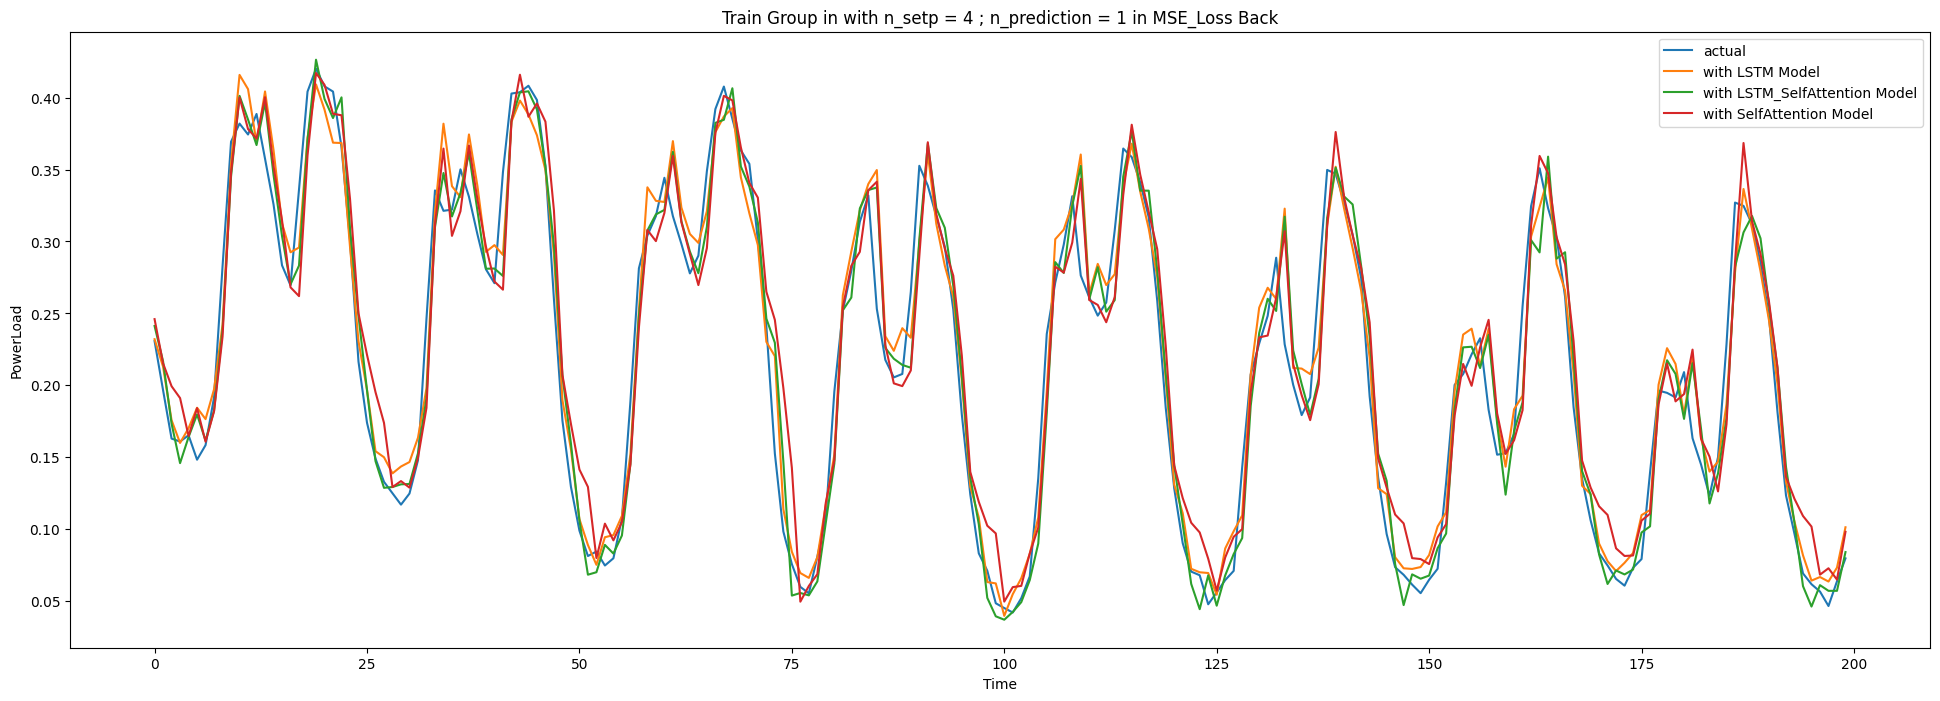

In [63]:
plt.plot(rY_train1[n1 :n2], label='actual' )
plt.plot(dt_train1[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_train4[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_train7[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Train Group in with n_setp = 4 ; n_prediction = 1 in MSE_Loss Back' )
plt.legend()
plt.show()

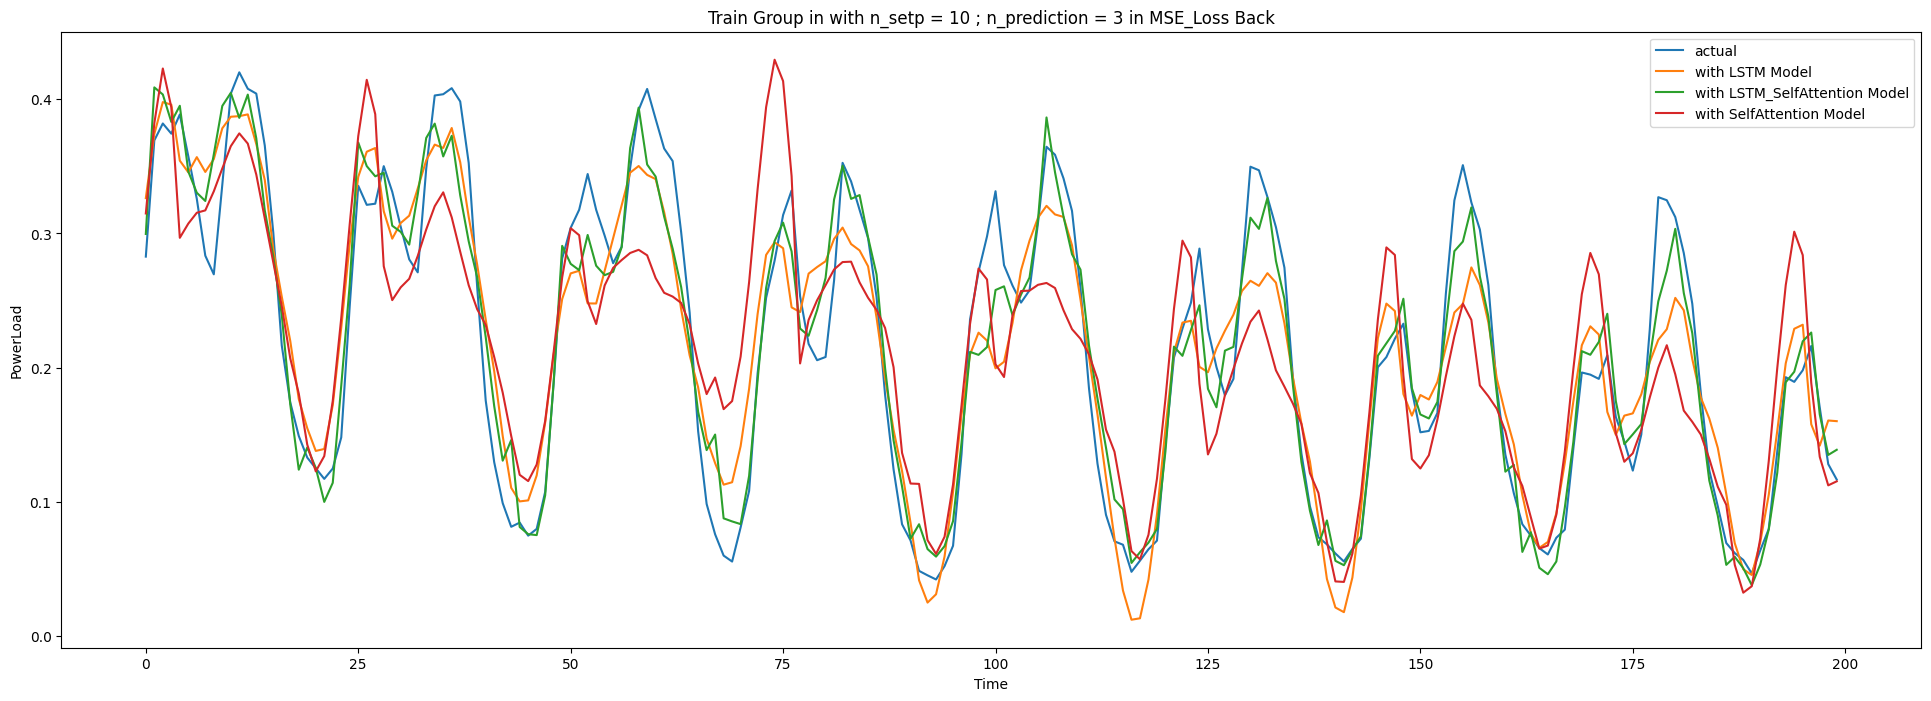

In [64]:
plt.plot(rY_train2[n1 :n2], label='actual' )
plt.plot(dt_train2[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_train5[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_train8[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Train Group in with n_setp = 10 ; n_prediction = 3 in MSE_Loss Back' )
plt.legend()
plt.show()

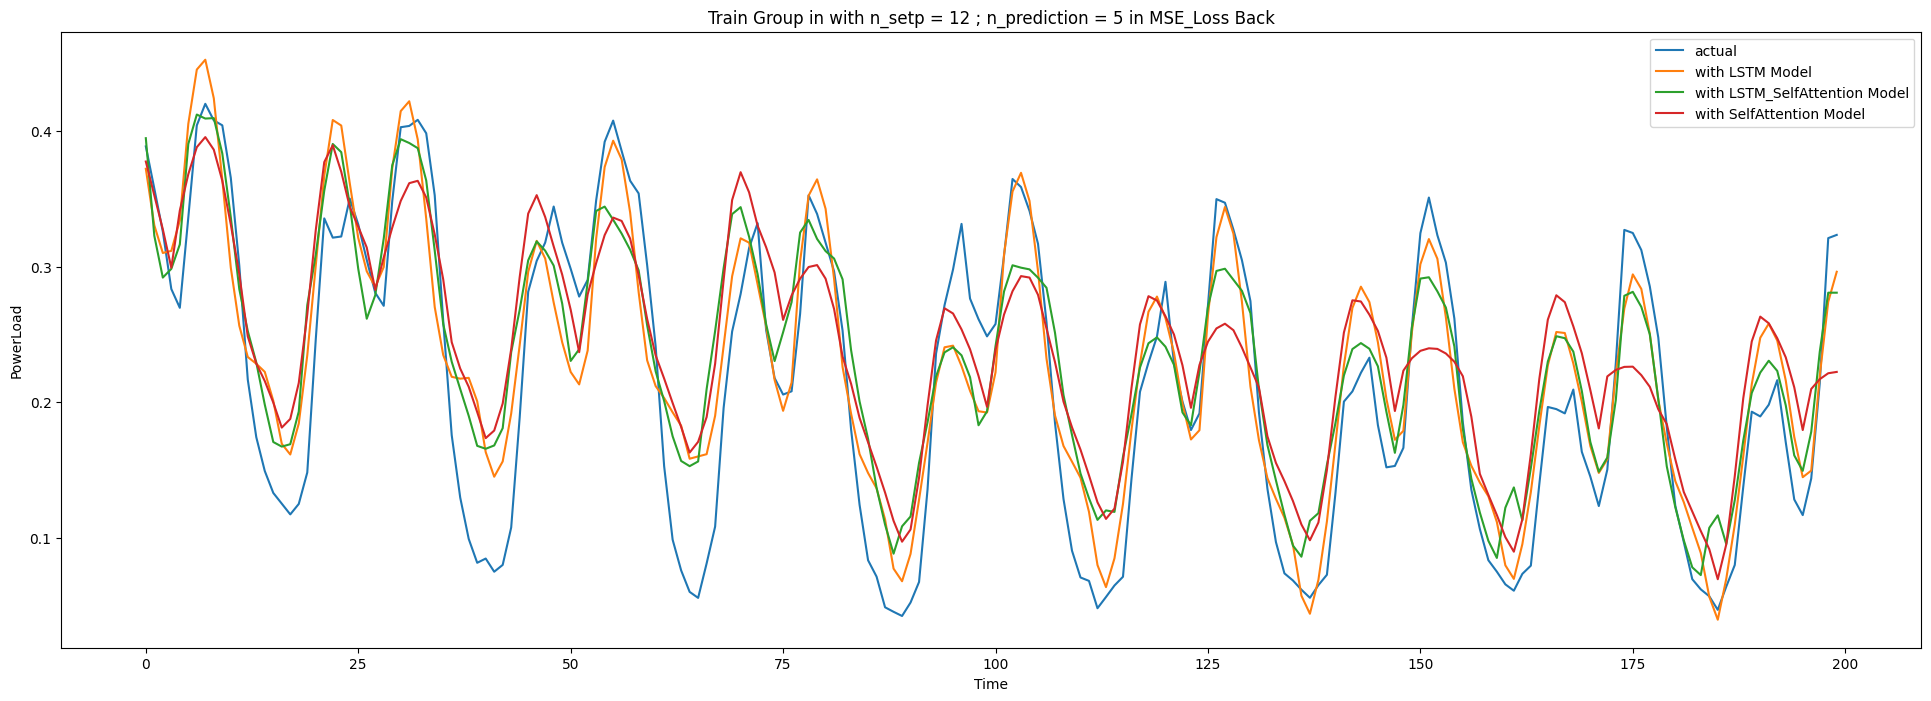

In [65]:
plt.plot(rY_train3[n1 :n2], label='actual' )
plt.plot(dt_train3[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_train6[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_train9[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Train Group in with n_setp = 12 ; n_prediction = 5 in MSE_Loss Back')
plt.legend()
plt.show()

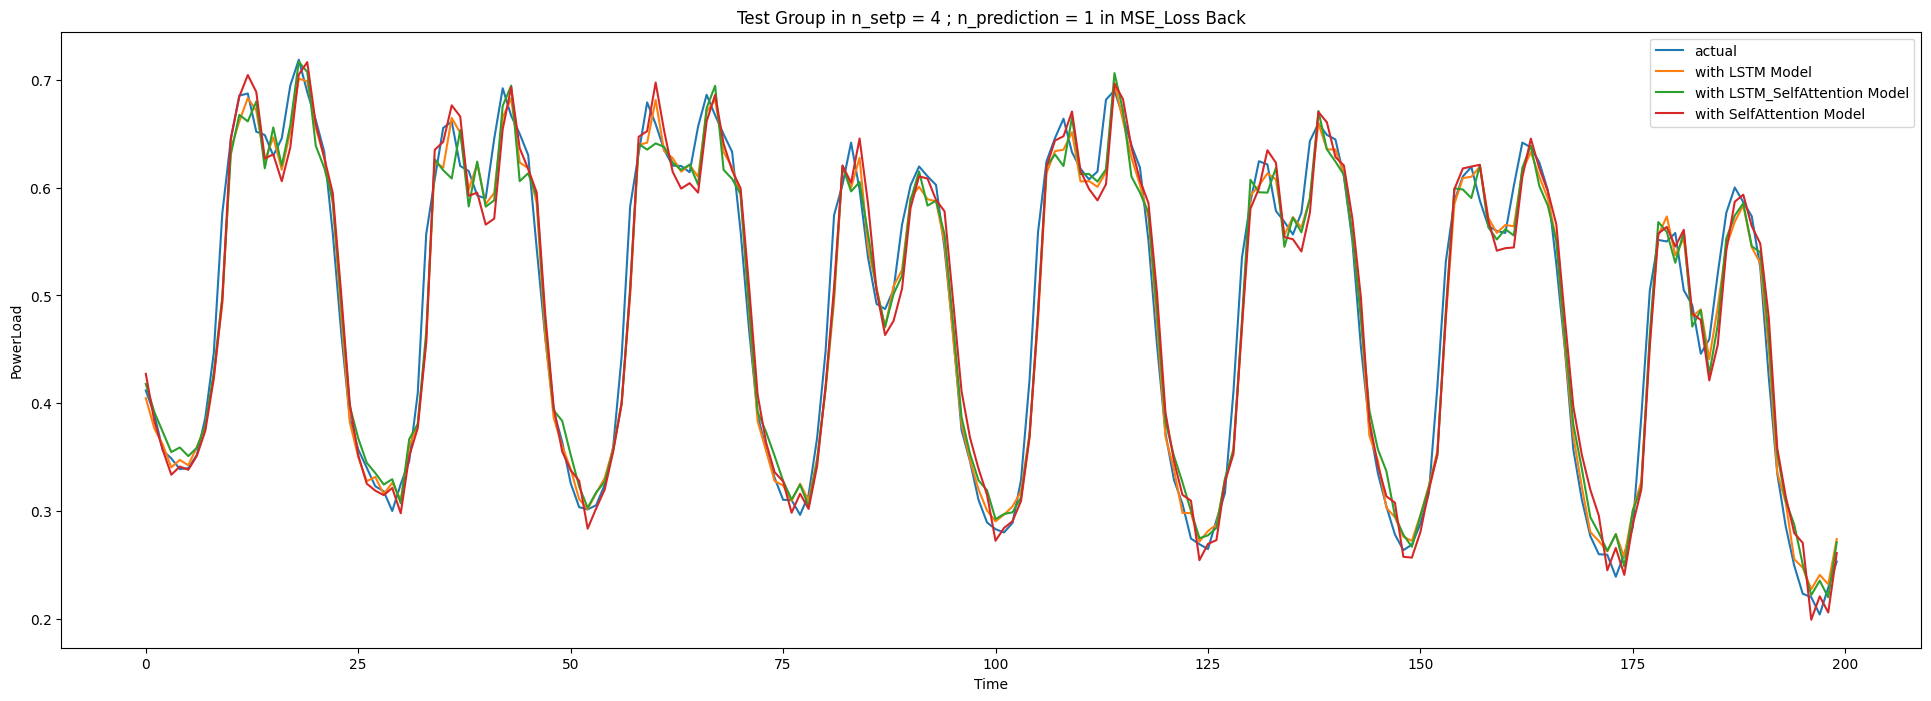

In [66]:
plt.plot(rY_test1[n1 :n2], label='actual' )
plt.plot(dt_test1[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_test4[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_test7[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Test Group in n_setp = 4 ; n_prediction = 1 in MSE_Loss Back')
plt.legend()
plt.show()

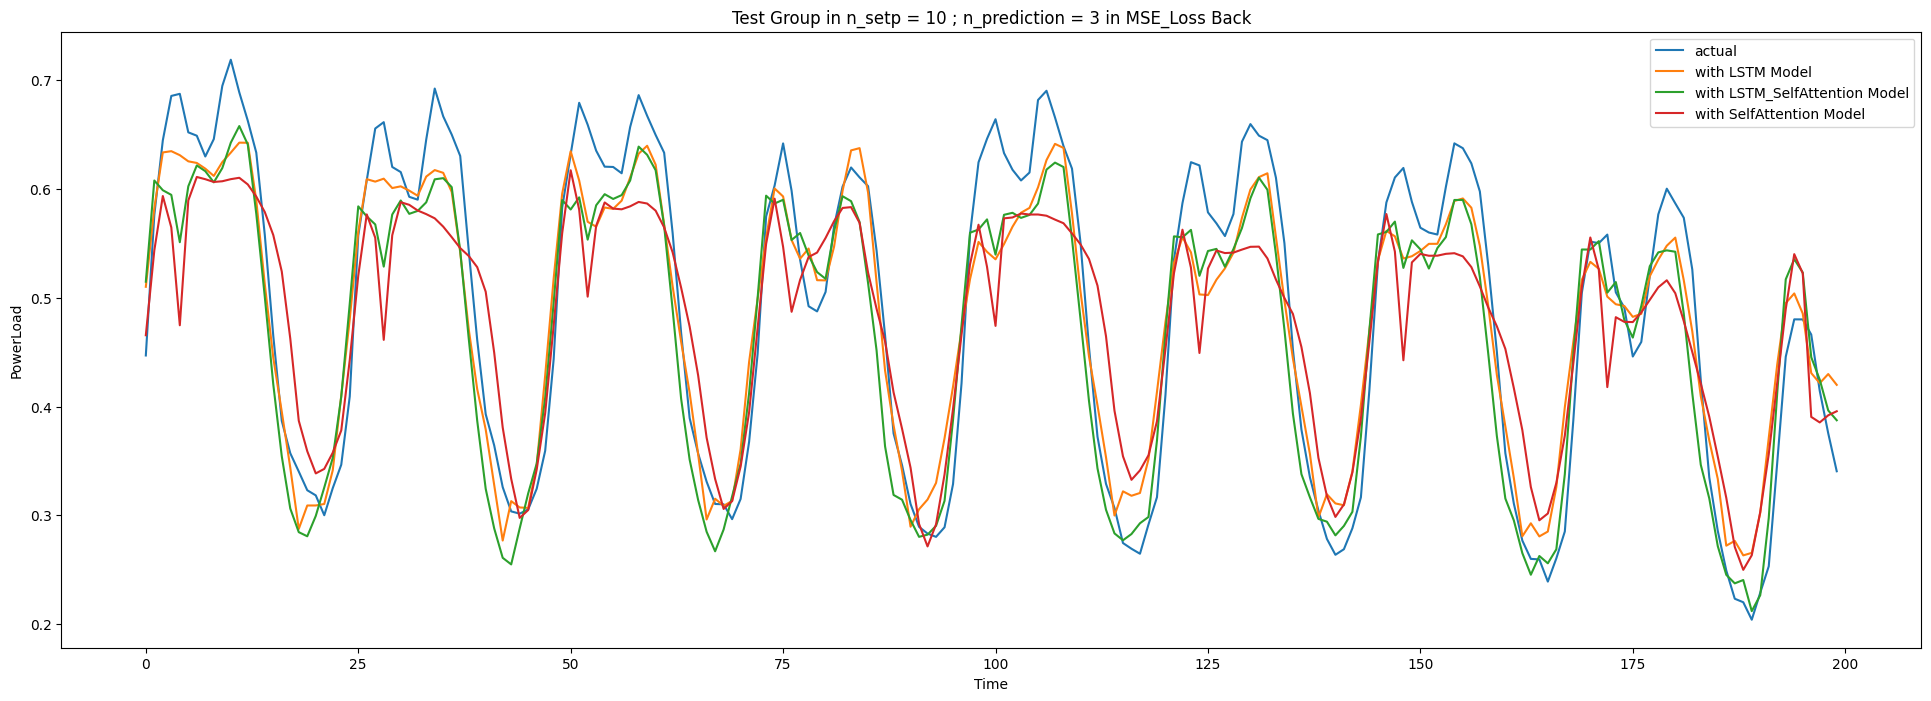

In [67]:
plt.plot(rY_test2[n1 :n2], label='actual' )
plt.plot(dt_test2[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_test5[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_test8[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Test Group in n_setp = 10 ; n_prediction = 3 in MSE_Loss Back')
plt.legend()
plt.show()

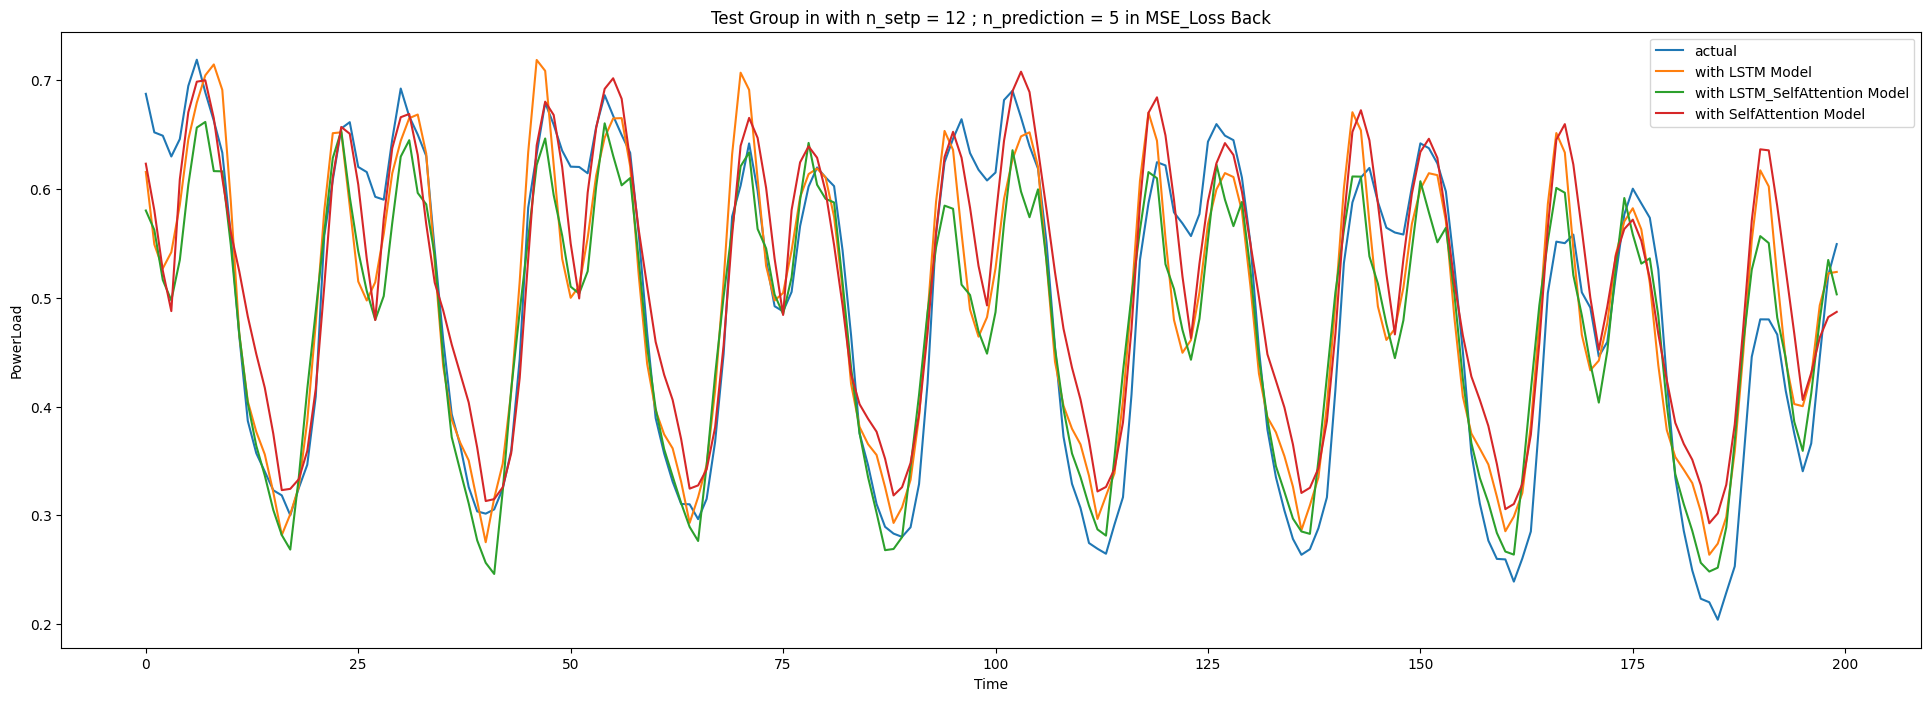

In [68]:
plt.plot(rY_test3[n1 :n2], label='actual' )
plt.plot(dt_test3[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_test6[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_test9[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Test Group in with n_setp = 12 ; n_prediction = 5 in MSE_Loss Back')
plt.legend()
plt.show()

In [69]:
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def MAPE(y_true, y_pred):
    actual, pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


RMSE OF LSTM MODEL : 0.0262
RMSE OF LSTM MODEL : 0.0420
RMSE OF LSTM MODEL : 0.0455
RMSE OF Self-Attention MODEL : 0.0321
RMSE OF Self-Attention MODEL : 0.0640
RMSE OF Self-Attention MODEL : 0.0622
RMSE OF LSTM_SA MODEL : 0.0269
RMSE OF LSTM_SA MODEL : 0.0288
RMSE OF LSTM_SA MODEL : 0.0510


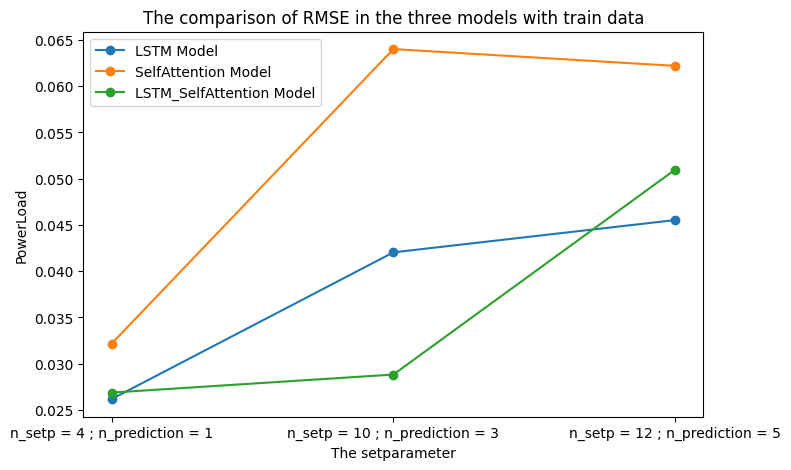

In [70]:
LSTM_RMSE_1 = RMSE(rY_train1[n1 :n2], dt_train1[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_1:.4f}")
LSTM_RMSE_2 = RMSE(rY_train2[n1 :n2], dt_train2[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_2:.4f}")
LSTM_RMSE_3 = RMSE(rY_train3[n1 :n2], dt_train3[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_3:.4f}")

SA_RMSE_1 = RMSE(rY_train1[n1 :n2], dt_train7[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_1:.4f}")
SA_RMSE_2 = RMSE(rY_train2[n1 :n2], dt_train8[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_2:.4f}")
SA_RMSE_3 = RMSE(rY_train3[n1 :n2], dt_train9[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_3:.4f}")

LSTM_SA_RMSE_1 = RMSE(rY_train1[n1 :n2], dt_train4[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_1:.4f}")
LSTM_SA_RMSE_2 = RMSE(rY_train2[n1 :n2], dt_train5[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_2:.4f}")
LSTM_SA_RMSE_3 = RMSE(rY_train3[n1 :n2], dt_train6[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_3:.4f}")

L = [LSTM_RMSE_1,LSTM_RMSE_2,LSTM_RMSE_3]
S = [SA_RMSE_1,SA_RMSE_2,SA_RMSE_3]
LS = [LSTM_SA_RMSE_1,LSTM_SA_RMSE_2,LSTM_SA_RMSE_3]

group = ["n_setp = 4 ; n_prediction = 1","n_setp = 10 ; n_prediction = 3","n_setp = 12 ; n_prediction = 5"]
plt.figure(figsize=(8,5))
plt.plot(group,L, label='LSTM Model', marker="o")
plt.plot(group,S, label='SelfAttention Model', marker="o")
plt.plot(group,LS, label='LSTM_SelfAttention Model', marker="o")
plt.xlabel('The setparameter')
plt.ylabel('PowerLoad')
plt.title('The comparison of RMSE in the three models with train data')
plt.legend()
plt.show()

MAPE OF LSTM MODEL in with n_setp = 4 ; n_prediction = 1 : 11.7210 %
MAPE OF LSTM MODEL in with n_setp = 10 ; n_prediction = 3 : 21.0734 %
MAPE OF LSTM MODEL in with n_setp = 12 ; n_prediction = 5 : 27.0377 %
MAPE OF Self-Attention MODEL in with n_setp = 4 ; n_prediction = 1 : 16.7550 %
MAPE OF Self-Attention MODEL in with n_setp = 10 ; n_prediction = 3 : 29.8104 %
MAPE OF Self-Attention MODEL in with n_setp = 12 ; n_prediction = 5 : 41.4018 %
MAPE OF LSTM_SA MODEL in with n_setp = 4 ; n_prediction = 1 : 11.2223 %
MAPE OF LSTM_SA MODEL in with n_setp = 10 ; n_prediction = 3 : 12.5246 %
MAPE OF LSTM_SA MODEL in with n_setp = 12 ; n_prediction = 5 : 34.0345 %


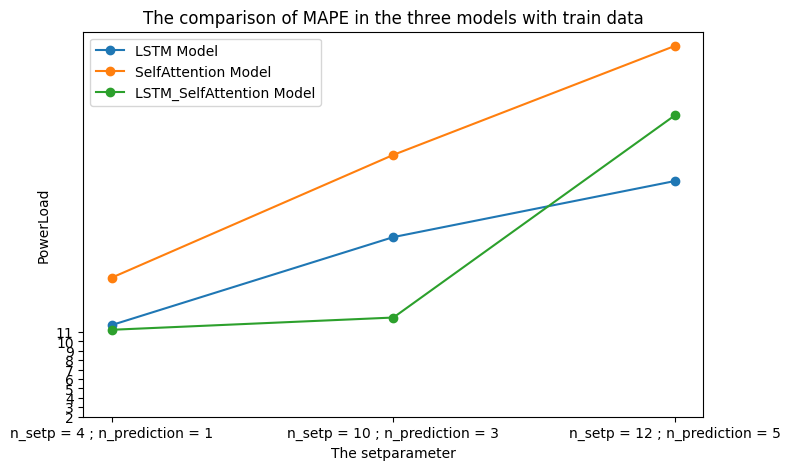

In [71]:
LSTM_MAPE_1 = MAPE(rY_train1[n1 :n2], dt_train1[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 4 ; n_prediction = 1 : {LSTM_MAPE_1:.4f} %")
LSTM_MAPE_2 = MAPE(rY_train2[n1 :n2], dt_train2[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 10 ; n_prediction = 3 : {LSTM_MAPE_2:.4f} %")
LSTM_MAPE_3 = MAPE(rY_train3[n1 :n2], dt_train3[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 12 ; n_prediction = 5 : {LSTM_MAPE_3:.4f} %")

SA_MAPE_1 = MAPE(rY_train1[n1 :n2], dt_train7[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 4 ; n_prediction = 1 : {SA_MAPE_1:.4f} %")
SA_MAPE_2 = MAPE(rY_train2[n1 :n2], dt_train8[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 10 ; n_prediction = 3 : {SA_MAPE_2:.4f} %")
SA_MAPE_3 = MAPE(rY_train3[n1 :n2], dt_train9[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 12 ; n_prediction = 5 : {SA_MAPE_3:.4f} %")

LSTM_SA_MAPE_1 = MAPE(rY_train1[n1 :n2], dt_train4[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 4 ; n_prediction = 1 : {LSTM_SA_MAPE_1:.4f} %")
LSTM_SA_MAPE_2 = MAPE(rY_train2[n1 :n2], dt_train5[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 10 ; n_prediction = 3 : {LSTM_SA_MAPE_2:.4f} %")
LSTM_SA_MAPE_3 = MAPE(rY_train3[n1 :n2], dt_train6[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 12 ; n_prediction = 5 : {LSTM_SA_MAPE_3:.4f} %")

L = [LSTM_MAPE_1,LSTM_MAPE_2,LSTM_MAPE_3]
S = [SA_MAPE_1,SA_MAPE_2,SA_MAPE_3]
LS = [LSTM_SA_MAPE_1,LSTM_SA_MAPE_2,LSTM_SA_MAPE_3]

group = ["n_setp = 4 ; n_prediction = 1","n_setp = 10 ; n_prediction = 3","n_setp = 12 ; n_prediction = 5"]
plt.figure(figsize=(8,5))
plt.plot(group,L, label='LSTM Model', marker="o")
plt.plot(group,S, label='SelfAttention Model', marker="o")
plt.plot(group,LS, label='LSTM_SelfAttention Model', marker="o")
plt.yticks(np.arange(2,12))
plt.xlabel('The setparameter')
plt.ylabel('PowerLoad')
plt.title('The comparison of MAPE in the three models with train data')
plt.legend()
plt.show()

RMSE OF LSTM MODEL : 0.0256
RMSE OF LSTM MODEL : 0.0477
RMSE OF LSTM MODEL : 0.0586
RMSE OF Self-Attention MODEL : 0.0308
RMSE OF Self-Attention MODEL : 0.0707
RMSE OF Self-Attention MODEL : 0.0602
RMSE OF LSTM_SA MODEL : 0.0282
RMSE OF LSTM_SA MODEL : 0.0511
RMSE OF LSTM_SA MODEL : 0.0585


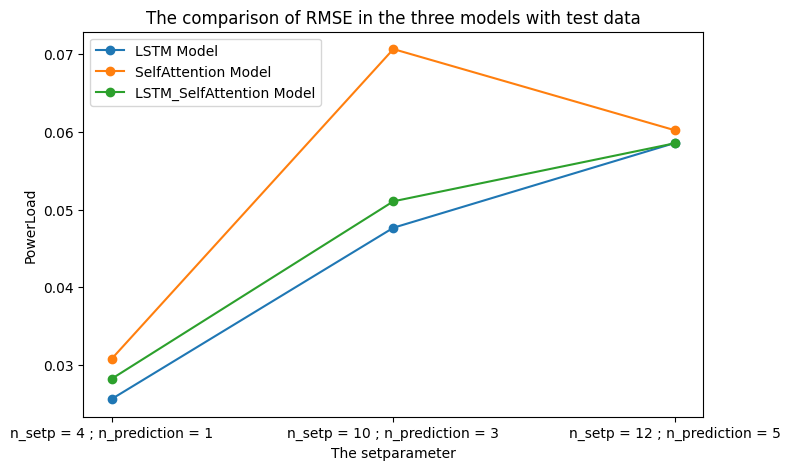

In [72]:
LSTM_RMSE_1 = RMSE(rY_test1[n1 :n2], dt_test1[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_1:.4f}")
LSTM_RMSE_2 = RMSE(rY_test2[n1 :n2], dt_test2[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_2:.4f}")
LSTM_RMSE_3 = RMSE(rY_test3[n1 :n2], dt_test3[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_3:.4f}")

SA_RMSE_1 = RMSE(rY_test1[n1 :n2], dt_test7[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_1:.4f}")
SA_RMSE_2 = RMSE(rY_test2[n1 :n2], dt_test8[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_2:.4f}")
SA_RMSE_3 = RMSE(rY_test3[n1 :n2], dt_test9[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_3:.4f}")

LSTM_SA_RMSE_1 = RMSE(rY_test1[n1 :n2], dt_test4[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_1:.4f}")
LSTM_SA_RMSE_2 = RMSE(rY_test2[n1 :n2], dt_test5[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_2:.4f}")
LSTM_SA_RMSE_3 = RMSE(rY_test3[n1 :n2], dt_test6[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_3:.4f}")

L = [LSTM_RMSE_1,LSTM_RMSE_2,LSTM_RMSE_3]
S = [SA_RMSE_1,SA_RMSE_2,SA_RMSE_3]
LS = [LSTM_SA_RMSE_1,LSTM_SA_RMSE_2,LSTM_SA_RMSE_3]

group = ["n_setp = 4 ; n_prediction = 1","n_setp = 10 ; n_prediction = 3","n_setp = 12 ; n_prediction = 5"]
plt.figure(figsize=(8,5))
plt.plot(group,L, label='LSTM Model', marker="o")
plt.plot(group,S, label='SelfAttention Model', marker="o")
plt.plot(group,LS, label='LSTM_SelfAttention Model', marker="o")
plt.xlabel('The setparameter')
plt.ylabel('PowerLoad')
plt.title('The comparison of RMSE in the three models with test data')
plt.legend()
plt.show()

MAPE OF LSTM MODEL in with n_setp = 4 ; n_prediction = 1 : 3.9092 %
MAPE OF LSTM MODEL in with n_setp = 10 ; n_prediction = 3 : 8.9281 %
MAPE OF LSTM MODEL in with n_setp = 12 ; n_prediction = 5 : 10.7283 %
MAPE OF Self-Attention MODEL in with n_setp = 4 ; n_prediction = 1 : 5.1792 %
MAPE OF Self-Attention MODEL in with n_setp = 10 ; n_prediction = 3 : 12.7717 %
MAPE OF Self-Attention MODEL in with n_setp = 12 ; n_prediction = 5 : 12.1481 %
MAPE OF LSTM_SA MODEL in with n_setp = 4 ; n_prediction = 1 : 4.8663 %
MAPE OF LSTM_SA MODEL in with n_setp = 10 ; n_prediction = 3 : 8.8720 %
MAPE OF LSTM_SA MODEL in with n_setp = 12 ; n_prediction = 5 : 9.7290 %


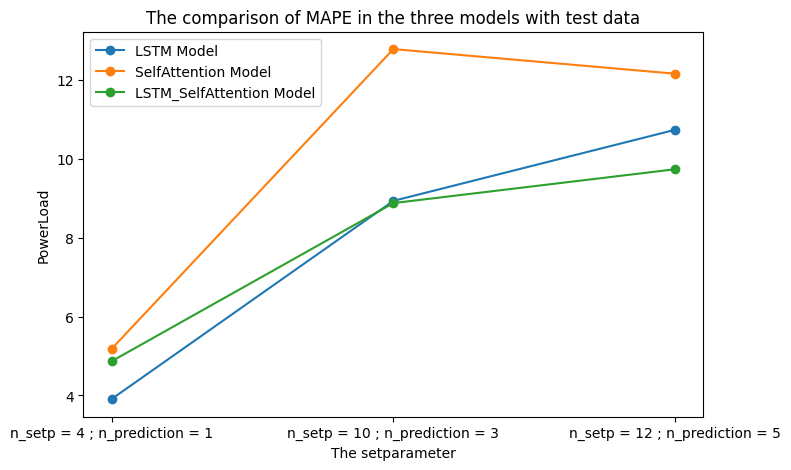

In [73]:
LSTM_MAPE_1 = MAPE(rY_test1[n1 :n2], dt_test1[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 4 ; n_prediction = 1 : {LSTM_MAPE_1:.4f} %")
LSTM_MAPE_2 = MAPE(rY_test2[n1 :n2], dt_test2[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 10 ; n_prediction = 3 : {LSTM_MAPE_2:.4f} %")
LSTM_MAPE_3 = MAPE(rY_test3[n1 :n2], dt_test3[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 12 ; n_prediction = 5 : {LSTM_MAPE_3:.4f} %")

SA_MAPE_1 = MAPE(rY_test1[n1 :n2], dt_test7[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 4 ; n_prediction = 1 : {SA_MAPE_1:.4f} %")
SA_MAPE_2 = MAPE(rY_test2[n1 :n2], dt_test8[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 10 ; n_prediction = 3 : {SA_MAPE_2:.4f} %")
SA_MAPE_3 = MAPE(rY_test3[n1 :n2], dt_test9[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 12 ; n_prediction = 5 : {SA_MAPE_3:.4f} %")

LSTM_SA_MAPE_1 = MAPE(rY_test1[n1 :n2], dt_test4[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 4 ; n_prediction = 1 : {LSTM_SA_MAPE_1:.4f} %")
LSTM_SA_MAPE_2 = MAPE(rY_test2[n1 :n2], dt_test5[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 10 ; n_prediction = 3 : {LSTM_SA_MAPE_2:.4f} %")
LSTM_SA_MAPE_3 = MAPE(rY_test3[n1 :n2], dt_test6[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 12 ; n_prediction = 5 : {LSTM_SA_MAPE_3:.4f} %")

L = [LSTM_MAPE_1,LSTM_MAPE_2,LSTM_MAPE_3]
S = [SA_MAPE_1,SA_MAPE_2,SA_MAPE_3]
LS = [LSTM_SA_MAPE_1,LSTM_SA_MAPE_2,LSTM_SA_MAPE_3]

group = ["n_setp = 4 ; n_prediction = 1","n_setp = 10 ; n_prediction = 3","n_setp = 12 ; n_prediction = 5"]
plt.figure(figsize=(8,5))
plt.plot(group,L, label='LSTM Model', marker="o")
plt.plot(group,S, label='SelfAttention Model', marker="o")
plt.plot(group,LS, label='LSTM_SelfAttention Model', marker="o")
plt.xlabel('The setparameter')
plt.ylabel('PowerLoad')
plt.title('The comparison of MAPE in the three models with test data')
plt.legend()
plt.show()